## Md Asif Rahman, ID. 114084345

## Recurrent Neural Networks

Recurrent Neural Networks (RNN) works based on the sequence continuation. We might not only receive a sequence as an input but rather might be expected to continue the sequence.
For example, the task could be to continue the series $2, 4, 6, 8, \ldots$ We want to have models that can handle such data.

RNNs are designed to better handle sequential information compared to CNNs [1]. RNNs introduce state variables to store past information, together with the current inputs, to determine the current outputs [1].

One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. However, in practice, RNNs don’t seem to be able to learn them even though theoratically, RNNs are absolutely capable of handling such “long-term dependencies.” Thankfully, LSTMs don’t have this problem!

## LSTM 
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies [2]. LSTMs are explicitly designed to avoid the long-term dependency problem, i.e., remembering information for long periods of time.

RNNs have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module have a very simple structure, such as a single tanh layer [3].

<img src="LSTM1.png">

|  | 
|:--:|
| *Fig. 1: Repeating Module in Standard RNN [3]* |

LSTMs along with this chain like structure contains a different structure in the repeating module [3]. Instead of having a single neural network layer, there are four, interacting in a very special way.

<img src="LSTM2.png">

|  | 
|:--:|
| *Fig. 2: Repeating Module in LSTM [3]* |

### Problem Statement:

Alkali–silica reaction (ASR) is a long-time degradation process [4]. Simulation modeling based on the inherent chemical reactions is quite complex and computationally very expensive. There might be convergence issues as well depending on the complex heterogenous concrete geometry. Moreover, available lab tests are limited to very short time frame, and can not infer data accurately for such a long-term phenomena. Therefore, a rigorous machine learning-induced method for the  prediction of ASR expansion is highly desirable. However, ASR modeling needs time series analysis along with a scope of gathering sequencial information, in terms of ASR's long time expansion. LSTM algorithm can be useful in this case which is capable of learning long-term dependencies. 

Within this context, I will utilize LSTM approach for the prediction modeling of ASR expansion. Input data for learning are used based on the generated sample data from my generative adversarial network (GAN) code. I am implementing both univariate and multivariate time series for the ASR prediction following the weather conditions [5]. I will also implement a simple 1D CNN to compare the results with LSTM.

In [1]:
import time
from datetime import timedelta
start_time = time.monotonic()

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2022-04-14 13:46:01.500078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 13:46:01.500108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from matplotlib import style
from matplotlib import pyplot as plt

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Case 1: 1 Year ASR Expansion with Constant Weather

## Loading Data for the Model Development

In [5]:
df_case1 = pd.read_csv('data_synthetic')  #Asif_GAN_2D generated data
df_case1.head()

,Datetime,exp
0,2022-01-22 21:24:29,0.003010
1,2022-01-23 04:42:44,0.003082
2,2022-01-23 06:01:41,0.003201
3,2022-01-23 15:45:21,0.003511
4,2022-01-23 16:34:53,0.003097


### Describing the dataset:

In [6]:
print("="*50)
print("First Five Rows ","\n")
print(df_case1.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_case1.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df_case1.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df_case1.isnull().sum(),"\n")

First Five Rows  

              Datetime       exp
0  2022-01-22 21:24:29  0.003010
1  2022-01-23 04:42:44  0.003082 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  1000 non-null   object 
 1   exp       1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB
None 

Describe the Dataset  

               exp
count  1000.000000
mean      0.069345
std       0.054350
min       0.002688
25%       0.010830
50%       0.075372
75%       0.125815
max       0.143310 

Null Values t  

Datetime    0
exp         0
dtype: int64 



### Feature engineering:

In [7]:
df_case1.index = pd.to_datetime(df_case1['Datetime'], format='%Y.%m.%d %H:%M:%S', errors='coerce')
df_case1[:5]

,Datetime,exp
Datetime,,
2022-01-22 21:24:29,2022-01-22 21:24:29,0.003010
2022-01-23 04:42:44,2022-01-23 04:42:44,0.003082
2022-01-23 06:01:41,2022-01-23 06:01:41,0.003201
2022-01-23 15:45:21,2022-01-23 15:45:21,0.003511
2022-01-23 16:34:53,2022-01-23 16:34:53,0.003097


#### Extracting all Data into Year, Month, Day, Time etc.:

In [8]:
# Extract all Data Like Year Month Day Time etc.
df_case1['Date'] = df_case1.index.date
df_case1['Year'] = df_case1.index.year
df_case1['Month'] = df_case1.index.month
df_case1['Day_of_Month'] = df_case1.index.day
df_case1['Week'] = df_case1.index.week
df_case1['Day'] = df_case1.index.day_name()
df_case1['Time'] = df_case1.index.time
df_case1['Hour'] = df_case1.index.hour
df_case1.head(5)

,Datetime,exp,Date,Year,Month,Day_of_Month,Week,Day,Time,Hour
Datetime,,,,,,,,,,
2022-01-22 21:24:29,2022-01-22 21:24:29,0.003010,2022-01-22,2022,1,22,3,Saturday,21:24:29,21
2022-01-23 04:42:44,2022-01-23 04:42:44,0.003082,2022-01-23,2022,1,23,3,Sunday,04:42:44,4
2022-01-23 06:01:41,2022-01-23 06:01:41,0.003201,2022-01-23,2022,1,23,3,Sunday,06:01:41,6
2022-01-23 15:45:21,2022-01-23 15:45:21,0.003511,2022-01-23,2022,1,23,3,Sunday,15:45:21,15
2022-01-23 16:34:53,2022-01-23 16:34:53,0.003097,2022-01-23,2022,1,23,3,Sunday,16:34:53,16


In [9]:
print(df_case1.Year.unique(),"\n")
print("Total Number of Unique Years", df_case1.Year.nunique(), "\n")

[2022 2023] 

Total Number of Unique Years 2 



#### Exploration:

Let’s start simple at the very beginning. We can have a look at the expansion over the whole time frame again.

In [10]:
df_case1['exp'] 

Datetime
2022-01-22 21:24:29    0.003010
2022-01-23 04:42:44    0.003082
2022-01-23 06:01:41    0.003201
2022-01-23 15:45:21    0.003511
2022-01-23 16:34:53    0.003097
                         ...   
2023-01-02 03:51:17    0.142326
2023-01-02 05:18:53    0.142479
2023-01-02 10:52:43    0.142659
2023-01-02 11:21:44    0.142822
2023-01-05 16:41:11    0.139891
Name: exp, Length: 1000, dtype: float64

<AxesSubplot:xlabel='Datetime'>

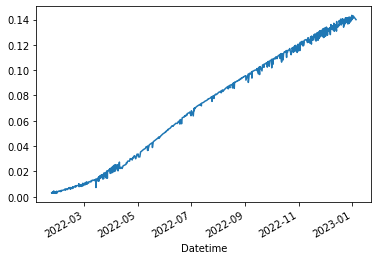

In [11]:
df_case1['exp'].plot()

Expansion is increasing with time.

Let's have a look at the expansion values by month.

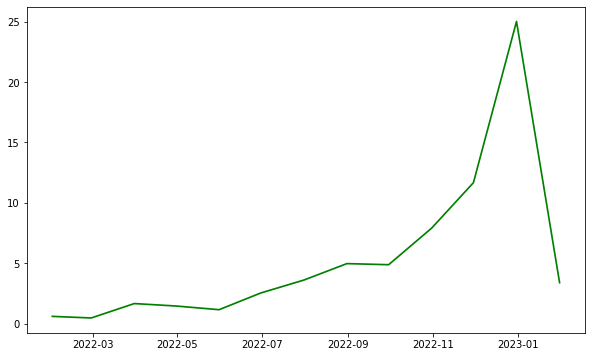

In [12]:
fig = plt.figure(figsize=(10, 6))
df_by_month=df_case1.resample('M').sum()
df_by_month
plt.plot(df_by_month.index,df_by_month['exp'], color="green", linewidth=1.7)

Expansion increases with an increasing rate as the time proceeds to the end of the year.

Let's have a look at the expansion values for different time parameters.

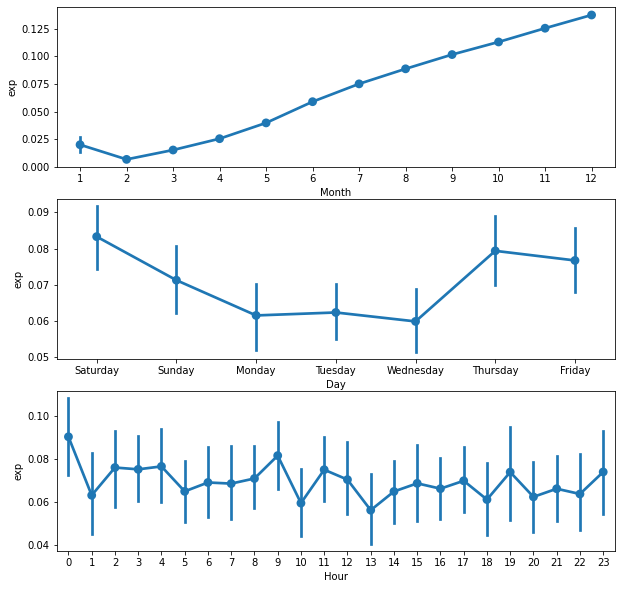

In [13]:
fig = plt.figure(figsize=(10, 10))
ax1= fig.add_subplot(311)
sns.pointplot(data=df_case1, x='Month', y='exp');

ax2= fig.add_subplot(312)
sns.pointplot(data=df_case1, x='Day', y='exp');

ax3= fig.add_subplot(313)
sns.pointplot(data=df_case1, x='Hour', y='exp');

Progression of month has impactr on the expansion values. Days or the hourly progress do not impact that much as the expansion needs long time to show up under the chemical reaction.

Let's see the distribution of the expansion values.

Text(0.5, 1.0, 'Average expansion')

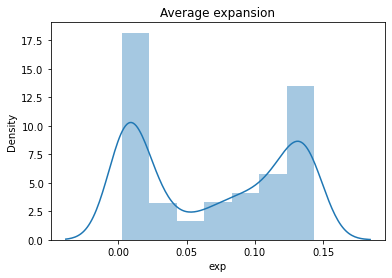

In [14]:
sns.distplot(df_case1["exp"])
plt.title("Average expansion")

The feature engineering efforts seem to be paying off. The new features separate the data very well.
Let's use the last 80% of the data for training (up to Nov 2022).

In [15]:
Train_percent=0.8
Val_percent=0.1
Test_percent=0.1

In [16]:
A=int(Train_percent*1000)   
B=int(A+Val_percent *1000)  

Let's set the time step based on the visualized data.

In [17]:
Time_steps = 10 #Input=No. of time steps

Let's split the datetimes based on train and test data separation.

In [18]:
dates1=df_case1[:A].index.to_list()
dates2=df_case1[A:B].index.to_list()
dates3=df_case1[B:-Time_steps].index.to_list()
dates3

[Timestamp('2022-12-26 04:51:17'),
 Timestamp('2022-12-26 05:51:56'),
 Timestamp('2022-12-26 09:12:29'),
 Timestamp('2022-12-26 15:28:33'),
 Timestamp('2022-12-26 16:04:01'),
 Timestamp('2022-12-26 17:23:39'),
 Timestamp('2022-12-26 21:52:53'),
 Timestamp('2022-12-26 23:37:01'),
 Timestamp('2022-12-27 00:07:59'),
 Timestamp('2022-12-27 00:12:29'),
 Timestamp('2022-12-27 00:53:05'),
 Timestamp('2022-12-27 00:55:24'),
 Timestamp('2022-12-27 02:12:55'),
 Timestamp('2022-12-27 03:25:43'),
 Timestamp('2022-12-27 03:43:01'),
 Timestamp('2022-12-27 04:09:42'),
 Timestamp('2022-12-27 04:31:53'),
 Timestamp('2022-12-27 04:59:27'),
 Timestamp('2022-12-27 05:36:33'),
 Timestamp('2022-12-27 06:16:16'),
 Timestamp('2022-12-27 08:20:31'),
 Timestamp('2022-12-27 14:51:03'),
 Timestamp('2022-12-27 17:55:31'),
 Timestamp('2022-12-27 18:08:52'),
 Timestamp('2022-12-27 19:11:54'),
 Timestamp('2022-12-27 23:49:35'),
 Timestamp('2022-12-28 00:53:30'),
 Timestamp('2022-12-28 02:04:37'),
 Timestamp('2022-12-

## Forecasting with a Univariate Time Series

### Preprocessing:

In [19]:
df_uni = df_case1['exp'] 

In [20]:
df_uni.shape

(1000,)

In [21]:
#For a time steps of 5:
# exp data at different times to predict exp at time 6
# [[[1], [2], [3], [4], [5]]] [6] 
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=Time_steps):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [22]:
X1, y1 = df_to_X_y(df_uni, Time_steps)
X1.shape, y1.shape

((990, 10, 1), (990,))

In [23]:
X_train1, y_train1 = X1[:A], y1[:A]
X_val1, y_val1 = X1[A:B], y1[A:B]
X_test1, y_test1 = X1[B:], y1[B:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((800, 10, 1), (800,), (100, 10, 1), (100,), (90, 10, 1), (90,))

## LSTM Approach

In [24]:
model1 = Sequential()
model1.add(InputLayer((10, 1)))  #window size = (10, 1): time steps = 10, variable of interest =1 
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2022-04-14 13:46:08.624924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-14 13:46:08.624958: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-14 13:46:08.624979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (asif-VirtualBox): /proc/driver/nvidia/version does not exist
2022-04-14 13:46:08.625282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [25]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
#model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

Remember to NOT shuffle the data when training:

In [26]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=150, shuffle =False, callbacks=[cp1]) 

Epoch 1/150
21/25 [========================>.....] - ETA: 0s - loss: 6.9931e-05 - root_mean_squared_error: 0.0084

2022-04-14 13:46:14.288295: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 9s 297ms/step - loss: 6.6034e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.3453e-04 - val_root_mean_squared_error: 0.0116
Epoch 2/150
20/25 [=======================>......] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0467

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 5s 224ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 1.2860e-04 - val_root_mean_squared_error: 0.0113
Epoch 3/150
25/25 [==============================] - 0s 14ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 3.8743e-04 - val_root_mean_squared_error: 0.0197
Epoch 4/150
25/25 [==============================] - ETA: 0s - loss: 3.9402e-04 - root_mean_squared_error: 0.0198

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 6s 238ms/step - loss: 3.9402e-04 - root_mean_squared_error: 0.0198 - val_loss: 5.1879e-05 - val_root_mean_squared_error: 0.0072
Epoch 5/150
25/25 [==============================] - 0s 13ms/step - loss: 6.0316e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.1764e-04 - val_root_mean_squared_error: 0.0108
Epoch 6/150
21/25 [========================>.....] - ETA: 0s - loss: 1.1765e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 6s 252ms/step - loss: 1.1196e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.0743e-05 - val_root_mean_squared_error: 0.0033
Epoch 7/150
25/25 [==============================] - 0s 18ms/step - loss: 7.0492e-05 - root_mean_squared_error: 0.0084 - val_loss: 6.0245e-05 - val_root_mean_squared_error: 0.0078
Epoch 8/150
25/25 [==============================] - 0s 16ms/step - loss: 9.6489e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.9923e-05 - val_root_mean_squared_error: 0.0063
Epoch 9/150
22/25 [=========================>....] - ETA: 0s - loss: 5.4047e-06 - root_mean_squared_error: 0.0023

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 5s 227ms/step - loss: 5.5489e-06 - root_mean_squared_error: 0.0024 - val_loss: 3.2229e-06 - val_root_mean_squared_error: 0.0018
Epoch 10/150
25/25 [==============================] - 0s 12ms/step - loss: 1.2310e-05 - root_mean_squared_error: 0.0035 - val_loss: 7.1563e-06 - val_root_mean_squared_error: 0.0027
Epoch 11/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7301e-05 - root_mean_squared_error: 0.0042 - val_loss: 8.3100e-06 - val_root_mean_squared_error: 0.0029
Epoch 12/150
25/25 [==============================] - 0s 12ms/step - loss: 2.4564e-05 - root_mean_squared_error: 0.0050 - val_loss: 1.0301e-05 - val_root_mean_squared_error: 0.0032
Epoch 13/150
25/25 [==============================] - 0s 13ms/step - loss: 3.3877e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.2968e-05 - val_root_mean_squared_error: 0.0036
Epoch 14/150
25/25 [==============================] - 0s 13ms/step - loss: 4.6020e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 6s 241ms/step - loss: 1.1262e-05 - root_mean_squared_error: 0.0034 - val_loss: 3.0487e-06 - val_root_mean_squared_error: 0.0017
Epoch 28/150
24/25 [===========================>..] - ETA: 0s - loss: 6.6601e-06 - root_mean_squared_error: 0.0026

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 6s 237ms/step - loss: 6.6545e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.0439e-06 - val_root_mean_squared_error: 0.0017
Epoch 29/150
22/25 [=========================>....] - ETA: 0s - loss: 3.5448e-06 - root_mean_squared_error: 0.0019

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


25/25 [==============================] - 6s 232ms/step - loss: 3.6954e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.0324e-06 - val_root_mean_squared_error: 0.0017
Epoch 30/150
25/25 [==============================] - 0s 9ms/step - loss: 3.4679e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.4137e-06 - val_root_mean_squared_error: 0.0018
Epoch 31/150
25/25 [==============================] - 0s 11ms/step - loss: 6.9162e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.7462e-06 - val_root_mean_squared_error: 0.0019
Epoch 32/150
25/25 [==============================] - 0s 9ms/step - loss: 1.8091e-05 - root_mean_squared_error: 0.0043 - val_loss: 5.5735e-06 - val_root_mean_squared_error: 0.0024
Epoch 33/150
25/25 [==============================] - 0s 8ms/step - loss: 3.2491e-05 - root_mean_squared_error: 0.0057 - val_loss: 6.6669e-06 - val_root_mean_squared_error: 0.0026
Epoch 34/150
25/25 [==============================] - 0s 8ms/step - loss: 5.8017e-05 - root_mean_squared_error

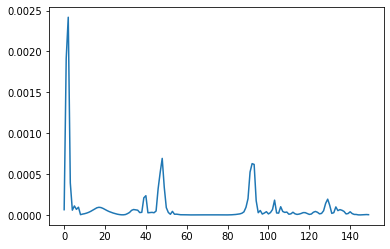

In [27]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [28]:
model1 = load_model('model1/')

### Model Evaluation:

In [29]:
#[test_loss, test_acc] = model1.evaluate(X_test1, y_test1)
#print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

In [30]:
def plot_predictions(model, X, y, dates, range, start=0, end=1000):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Date':dates, 'Predictions':predictions, 'Actuals':y})
  df.index = pd.RangeIndex(range,range + len(df))
  plt.plot(df['Predictions'][start:end],color="red", label='Predictions')
  plt.plot(df['Actuals'][start:end], color="green", label='Actuals')
  plt.legend()
  return df

,Date,Predictions,Actuals
0,2022-01-22 21:24:29,0.004735,0.003251
1,2022-01-23 04:42:44,0.004739,0.003438
2,2022-01-23 06:01:41,0.004752,0.003545
3,2022-01-23 15:45:21,0.004769,0.003009
4,2022-01-23 16:34:53,0.004749,0.003429
...,...,...,...
795,2022-12-01 14:15:31,0.132076,0.132250
796,2022-12-01 21:17:53,0.132203,0.132081
797,2022-12-02 09:00:42,0.132430,0.127588
798,2022-12-02 12:24:05,0.131794,0.133123


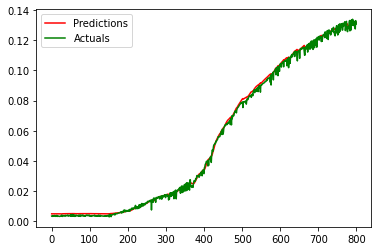

In [31]:
train_results = plot_predictions(model1, X_train1, y_train1, dates1, 0)
train_results.index = pd.RangeIndex(0,0 + len(train_results))
train_results

,Date,Predictions,Actuals
800,2022-12-02 19:08:43,0.131947,0.132992
801,2022-12-02 23:06:07,0.132089,0.130530
802,2022-12-03 01:38:45,0.131954,0.133631
803,2022-12-03 02:37:27,0.132326,0.131681
804,2022-12-03 05:54:57,0.132398,0.133496
...,...,...,...
895,2022-12-25 01:12:34,0.139826,0.141202
896,2022-12-25 04:50:52,0.140003,0.140130
897,2022-12-25 05:31:39,0.140086,0.140514
898,2022-12-25 07:24:30,0.140146,0.139959


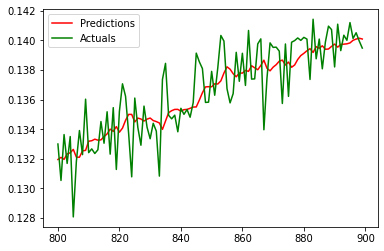

In [32]:
val_results = plot_predictions(model1, X_val1, y_val1, dates2, A)
val_results.index = pd.RangeIndex(A,A + len(val_results))
val_results

,Date,Predictions,Actuals
900,2022-12-26 04:51:17,0.139974,0.140039
901,2022-12-26 05:51:56,0.140010,0.140358
902,2022-12-26 09:12:29,0.140000,0.140753
903,2022-12-26 15:28:33,0.140109,0.136563
904,2022-12-26 16:04:01,0.139601,0.139990
...,...,...,...
985,2023-01-01 15:11:50,0.141286,0.142326
986,2023-01-01 15:15:02,0.141442,0.142479
987,2023-01-01 18:08:58,0.141602,0.142659
988,2023-01-01 19:23:54,0.141742,0.142822


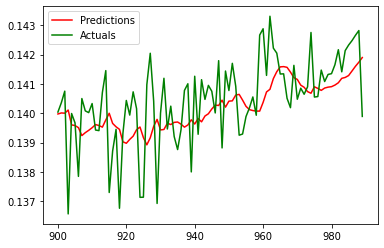

In [33]:
test_results = plot_predictions(model1, X_test1, y_test1, dates3, B)
test_results.index = pd.RangeIndex(B,B + len(test_results))
test_results

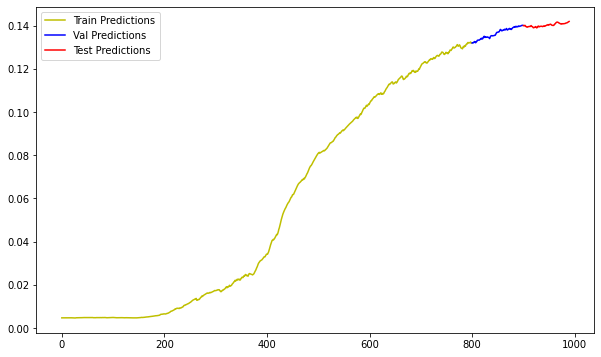

In [34]:
fig = plt.figure(figsize=(10, 6))
train_results['Predictions'].plot(color="y", label='Train Predictions')
val_results['Predictions'].plot(color="b", label='Val Predictions')
test_results['Predictions'].plot(color="r", label='Test Predictions')
plt.legend()

### Calculate RMSE performance metrics:

In [35]:
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Absolute Percentage Error
    me = np.mean(forecast - actual)             # Mean Error
    mae = np.mean(np.abs(forecast - actual))    # Mean Absolute Error
    mpe = np.mean((forecast - actual)/actual)   # Mean Percentage Error

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})

In [36]:
train_predictions = train_results['Predictions']
forecast_accuracy(train_predictions, y_train1)

{'mape': 0.10942611859811645,
 'me': 0.000857447298476519,
 'mae': 0.001378133370308224,
 'mpe': 0.08941009392021661,
 'rmse': 0.0018253590410531443,
 'acf1': 0.18444487400503817,
 'corr': 0.9994315365342223,
 'minmax': 0.08348908218244222}

In [37]:
val_predictions = val_results['Predictions']
forecast_accuracy(val_predictions, y_val1)

{'mape': 0.010355239061589938,
 'me': -0.00016761913895603804,
 'mae': 0.0014115445315837896,
 'mpe': -0.0010594929993640847,
 'rmse': 0.0017413665369995174,
 'acf1': -0.08654400271673748,
 'corr': 0.8256888048163158,
 'minmax': 0.010277044702230453}

In [38]:
test_predictions = test_results['Predictions']
forecast_accuracy(test_predictions, y_test1)

{'mape': 0.007198630325755403,
 'me': -0.00023637827899717048,
 'mae': 0.0010093866123093438,
 'mpe': -0.0016050218002418748,
 'rmse': 0.0012814084439194697,
 'acf1': 0.0589937712138335,
 'corr': 0.4791480647003241,
 'minmax': 0.007159824373531354}

### Combined result:

In [39]:
frames = [train_results, val_results, test_results]
result_uni = pd.concat(frames)
result_uni

,Date,Predictions,Actuals
0,2022-01-22 21:24:29,0.004735,0.003251
1,2022-01-23 04:42:44,0.004739,0.003438
2,2022-01-23 06:01:41,0.004752,0.003545
3,2022-01-23 15:45:21,0.004769,0.003009
4,2022-01-23 16:34:53,0.004749,0.003429
...,...,...,...
985,2023-01-01 15:11:50,0.141286,0.142326
986,2023-01-01 15:15:02,0.141442,0.142479
987,2023-01-01 18:08:58,0.141602,0.142659
988,2023-01-01 19:23:54,0.141742,0.142822


In [40]:
result_uni.index = pd.to_datetime(result_uni['Date'], format='%Y.%m.%d %H:%M:%S')
result_uni

,Date,Predictions,Actuals
Date,,,
2022-01-22 21:24:29,2022-01-22 21:24:29,0.004735,0.003251
2022-01-23 04:42:44,2022-01-23 04:42:44,0.004739,0.003438
2022-01-23 06:01:41,2022-01-23 06:01:41,0.004752,0.003545
2022-01-23 15:45:21,2022-01-23 15:45:21,0.004769,0.003009
2022-01-23 16:34:53,2022-01-23 16:34:53,0.004749,0.003429
...,...,...,...
2023-01-01 15:11:50,2023-01-01 15:11:50,0.141286,0.142326
2023-01-01 15:15:02,2023-01-01 15:15:02,0.141442,0.142479
2023-01-01 18:08:58,2023-01-01 18:08:58,0.141602,0.142659


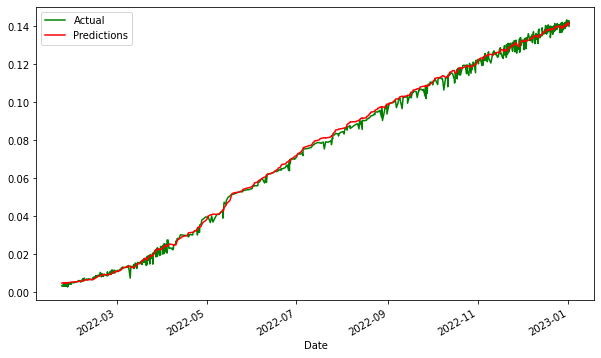

In [41]:
fig = plt.figure(figsize=(10, 6))
result_uni['Actuals'].plot(color="g", label='Actual')
result_uni['Predictions'].plot(color="r", label='Predictions')
plt.legend()

### Prediction of future values:

In [42]:
past_result=result_uni['Actuals'].tail(50) #last 50 time steps
past_result

Date
2022-12-29 02:24:23    0.141262
2022-12-29 03:01:55    0.139281
2022-12-29 04:01:41    0.141145
2022-12-29 04:13:47    0.140472
2022-12-29 06:21:13    0.140950
2022-12-29 14:51:11    0.140748
2022-12-29 17:32:58    0.140009
2022-12-29 17:37:36    0.141794
2022-12-30 00:47:22    0.138815
2022-12-30 01:46:45    0.141440
2022-12-30 02:30:11    0.140775
2022-12-30 05:33:27    0.141703
2022-12-30 06:33:06    0.140917
2022-12-30 06:58:32    0.139250
2022-12-30 09:30:59    0.139290
2022-12-30 12:27:21    0.139887
2022-12-30 13:46:14    0.140180
2022-12-30 14:53:32    0.140555
2022-12-30 21:56:17    0.139931
2022-12-31 00:05:43    0.142669
2022-12-31 01:36:42    0.142883
2022-12-31 03:34:00    0.141291
2022-12-31 06:13:05    0.143310
2022-12-31 08:22:43    0.142221
2022-12-31 09:12:13    0.142051
2022-12-31 09:45:10    0.141339
2022-12-31 09:57:27    0.141345
2022-12-31 15:26:46    0.140510
2022-12-31 17:28:12    0.140189
2022-12-31 18:20:27    0.141634
2022-12-31 19:12:01    0.140477
202

In [43]:
len(past_result)

50

In [44]:
past_result.shape #Getting the last 50 time steps

(50,)

In [45]:
past_result = past_result.values.reshape(1,-1) 
past_result.shape

(1, 50)

In [46]:
future_inp = list(past_result)   #past results for the future input
future_inp

[array([0.14126219, 0.13928118, 0.14114487, 0.1404722 , 0.14095044,
        0.1407482 , 0.1400094 , 0.14179394, 0.13881503, 0.14144015,
        0.1407752 , 0.14170322, 0.14091678, 0.13924992, 0.13928977,
        0.13988733, 0.14018041, 0.14055529, 0.13993102, 0.1426686 ,
        0.14288335, 0.14129107, 0.14331047, 0.14222127, 0.14205083,
        0.14133881, 0.14134452, 0.14050981, 0.14018908, 0.14163387,
        0.14047718, 0.14085457, 0.14064741, 0.14090085, 0.14275628,
        0.14055198, 0.1405687 , 0.14147224, 0.14108187, 0.14132416,
        0.14135003, 0.14165458, 0.142168  , 0.14141308, 0.14213651,
        0.14232621, 0.14247882, 0.14265892, 0.14282221, 0.13989082])]

In [47]:
#Predicting next 20 time steps data using the current data
#It will predict in sliding window manner/algorithm with a stride of 1
future_output_uni=[]  #future output in univariate time series
n_steps=50
i=0
while(i<20): #future 20 time steps
    
    if(len(future_inp)>n_steps): # starts counting after last 50 time steps
        past_result = np.array(future_inp[1:])
        past_result=past_result.reshape(1,-1)
        past_result = past_result.reshape((1, n_steps, 1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_inp = future_inp[1:]
        future_output_uni.extend(yhat.tolist())
        i=i+1
    else:
        past_result = past_result.reshape((1, n_steps,1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_output_uni.extend(yhat.tolist())
        i=i+1
    

print(future_output_uni)

[[0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553]]


In [48]:
#Creating a dummy plane to plot graph one after another
plot_act=np.arange(1,51) #last 50 time steps
plot_pred=np.arange(50,70) #future 20 time steps

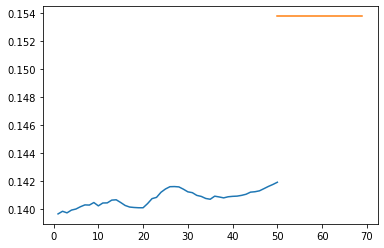

In [49]:
plt.plot(plot_act, result_uni['Predictions'][940:])  #last 50 time steps from total of 990 time steps
plt.plot(plot_pred, future_output_uni)

In [50]:
pred_uni = result_uni['Predictions'].tolist()

In [51]:
len(pred_uni)

990

In [52]:
pred_uni

[0.004735233262181282,
 0.004738925024867058,
 0.0047515518963336945,
 0.004768840968608856,
 0.004748751875013113,
 0.004757820162922144,
 0.00476437620818615,
 0.004749932326376438,
 0.004773017484694719,
 0.004789496771991253,
 0.004790276754647493,
 0.004801325500011444,
 0.004778825677931309,
 0.004788657184690237,
 0.00479601975530386,
 0.004811912775039673,
 0.0048096273094415665,
 0.00478773470968008,
 0.004768542014062405,
 0.004755936563014984,
 0.004743712954223156,
 0.004728683270514011,
 0.004712740425020456,
 0.004694384057074785,
 0.004681533668190241,
 0.0046777138486504555,
 0.0046763950958848,
 0.004722886718809605,
 0.004746386781334877,
 0.004779405891895294,
 0.004767166450619698,
 0.004779614973813295,
 0.004794474691152573,
 0.004810553044080734,
 0.0048309387639164925,
 0.004834357649087906,
 0.004814003594219685,
 0.004794835578650236,
 0.0048153577372431755,
 0.004828730598092079,
 0.004836163949221373,
 0.004837210290133953,
 0.004836617037653923,
 0.00486473

In [53]:
pred_uni_future = [item for sublist in future_output_uni for item in sublist]
pred_uni_future

[0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553]

In [54]:
#Entend helps us to fill the missing value with approx value
pred_uni.extend(pred_uni_future)
print('All Predicted List:', pred_uni)

All Predicted List: [0.004735233262181282, 0.004738925024867058, 0.0047515518963336945, 0.004768840968608856, 0.004748751875013113, 0.004757820162922144, 0.00476437620818615, 0.004749932326376438, 0.004773017484694719, 0.004789496771991253, 0.004790276754647493, 0.004801325500011444, 0.004778825677931309, 0.004788657184690237, 0.00479601975530386, 0.004811912775039673, 0.0048096273094415665, 0.00478773470968008, 0.004768542014062405, 0.004755936563014984, 0.004743712954223156, 0.004728683270514011, 0.004712740425020456, 0.004694384057074785, 0.004681533668190241, 0.0046777138486504555, 0.0046763950958848, 0.004722886718809605, 0.004746386781334877, 0.004779405891895294, 0.004767166450619698, 0.004779614973813295, 0.004794474691152573, 0.004810553044080734, 0.0048309387639164925, 0.004834357649087906, 0.004814003594219685, 0.004794835578650236, 0.0048153577372431755, 0.004828730598092079, 0.004836163949221373, 0.004837210290133953, 0.004836617037653923, 0.0048647355288267136, 0.00486829

In [55]:
len(pred_uni)

1010

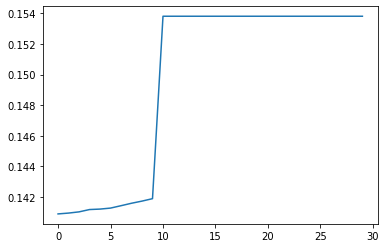

In [56]:
plt.plot(pred_uni[980:]) 

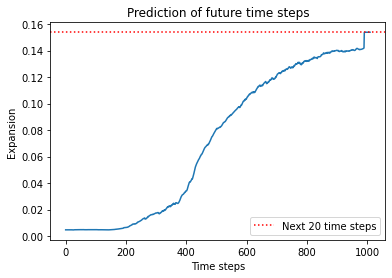

In [57]:
#Plotting final results with predicted value after 20 time steps
plt.plot(pred_uni)
plt.ylabel("Expansion")
plt.xlabel("Time steps")
plt.title("Prediction of future time steps")
plt.axhline(y=pred_uni[len(pred_uni)-1], color = 'red', linestyle = ':', label = 'Next 20 time steps')
plt.legend()

## Conv1D (1DCNN) Approach

In [58]:
model2 = Sequential()
model2.add(InputLayer((10, 1))) #window size = (10, 1): time steps = 10, variable of interest =1 
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             192       
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4616      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,817
Trainable params: 4,817
Non-trainable params: 0
_________________________________________________________________


In [59]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Remember to NOT shuffle the data when training:

In [60]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=150, shuffle =False, callbacks=[cp2])

Epoch 1/150
 1/25 [>.............................] - ETA: 11s - loss: 8.6617e-06 - root_mean_squared_error: 0.0029INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


25/25 [==============================] - 1s 38ms/step - loss: 3.6120e-05 - root_mean_squared_error: 0.0060 - val_loss: 6.4694e-06 - val_root_mean_squared_error: 0.0025
Epoch 2/150
25/25 [==============================] - 0s 3ms/step - loss: 7.6515e-04 - root_mean_squared_error: 0.0277 - val_loss: 3.6292e-04 - val_root_mean_squared_error: 0.0191
Epoch 3/150
 1/25 [>.............................] - ETA: 0s - loss: 8.2846e-04 - root_mean_squared_error: 0.0288INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


25/25 [==============================] - 1s 32ms/step - loss: 2.6059e-04 - root_mean_squared_error: 0.0161 - val_loss: 5.3964e-06 - val_root_mean_squared_error: 0.0023
Epoch 4/150
25/25 [==============================] - 0s 3ms/step - loss: 3.1432e-04 - root_mean_squared_error: 0.0177 - val_loss: 1.7812e-04 - val_root_mean_squared_error: 0.0133
Epoch 5/150
25/25 [==============================] - 0s 3ms/step - loss: 3.7815e-04 - root_mean_squared_error: 0.0194 - val_loss: 3.8926e-04 - val_root_mean_squared_error: 0.0197
Epoch 6/150
25/25 [==============================] - 0s 3ms/step - loss: 1.9975e-04 - root_mean_squared_error: 0.0141 - val_loss: 1.1408e-04 - val_root_mean_squared_error: 0.0107
Epoch 7/150
25/25 [==============================] - 0s 3ms/step - loss: 4.4752e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.8782e-05 - val_root_mean_squared_error: 0.0043
Epoch 8/150
 1/25 [>.............................] - ETA: 0s - loss: 3.7521e-05 - root_mean_squared_error: 0.0061INF

INFO:tensorflow:Assets written to: model2/assets


25/25 [==============================] - 1s 32ms/step - loss: 1.0584e-05 - root_mean_squared_error: 0.0033 - val_loss: 2.9903e-06 - val_root_mean_squared_error: 0.0017
Epoch 9/150
25/25 [==============================] - 0s 4ms/step - loss: 4.7914e-06 - root_mean_squared_error: 0.0022 - val_loss: 3.5001e-06 - val_root_mean_squared_error: 0.0019
Epoch 10/150
25/25 [==============================] - 0s 4ms/step - loss: 6.5695e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.1649e-06 - val_root_mean_squared_error: 0.0018
Epoch 11/150
25/25 [==============================] - 0s 4ms/step - loss: 1.7078e-05 - root_mean_squared_error: 0.0041 - val_loss: 1.3804e-05 - val_root_mean_squared_error: 0.0037
Epoch 12/150
25/25 [==============================] - 0s 3ms/step - loss: 2.7528e-05 - root_mean_squared_error: 0.0052 - val_loss: 2.9428e-05 - val_root_mean_squared_error: 0.0054
Epoch 13/150
25/25 [==============================] - 0s 3ms/step - loss: 2.3661e-05 - root_mean_squared_error: 0

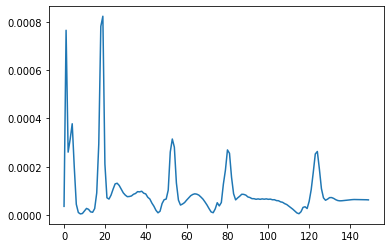

In [61]:
loss_per_epoch = model2.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [62]:
model2 = load_model('model2/')

### Model Evaluation:

,Date,Predictions,Actuals
0,2022-01-22 21:24:29,0.006167,0.003251
1,2022-01-23 04:42:44,0.006224,0.003438
2,2022-01-23 06:01:41,0.006217,0.003545
3,2022-01-23 15:45:21,0.006180,0.003009
4,2022-01-23 16:34:53,0.006222,0.003429
...,...,...,...
795,2022-12-01 14:15:31,0.131372,0.132250
796,2022-12-01 21:17:53,0.132976,0.132081
797,2022-12-02 09:00:42,0.132656,0.127588
798,2022-12-02 12:24:05,0.132322,0.133123


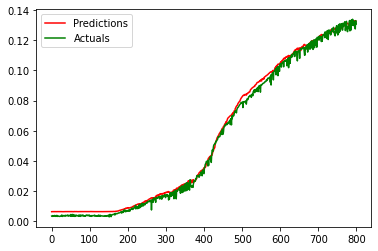

In [63]:
train_results = plot_predictions(model2, X_train1, y_train1, dates1, 0)
train_results.index = pd.RangeIndex(0,0 + len(train_results))
train_results

,Date,Predictions,Actuals
800,2022-12-02 19:08:43,0.131947,0.132992
801,2022-12-02 23:06:07,0.132089,0.130530
802,2022-12-03 01:38:45,0.131954,0.133631
803,2022-12-03 02:37:27,0.132326,0.131681
804,2022-12-03 05:54:57,0.132398,0.133496
...,...,...,...
895,2022-12-25 01:12:34,0.139826,0.141202
896,2022-12-25 04:50:52,0.140003,0.140130
897,2022-12-25 05:31:39,0.140086,0.140514
898,2022-12-25 07:24:30,0.140146,0.139959


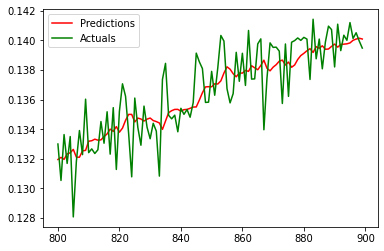

In [64]:
val_results = plot_predictions(model1, X_val1, y_val1, dates2, A)
val_results.index = pd.RangeIndex(A,A + len(val_results))
val_results

,Date,Predictions,Actuals
900,2022-12-26 04:51:17,0.139974,0.140039
901,2022-12-26 05:51:56,0.140010,0.140358
902,2022-12-26 09:12:29,0.140000,0.140753
903,2022-12-26 15:28:33,0.140109,0.136563
904,2022-12-26 16:04:01,0.139601,0.139990
...,...,...,...
985,2023-01-01 15:11:50,0.141286,0.142326
986,2023-01-01 15:15:02,0.141442,0.142479
987,2023-01-01 18:08:58,0.141602,0.142659
988,2023-01-01 19:23:54,0.141742,0.142822


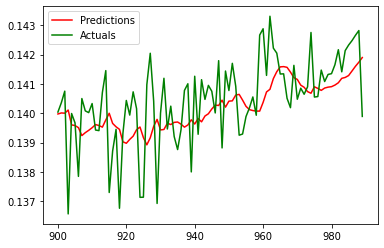

In [65]:
test_results = plot_predictions(model1, X_test1, y_test1, dates3, B)
test_results.index = pd.RangeIndex(B,B + len(test_results))
test_results

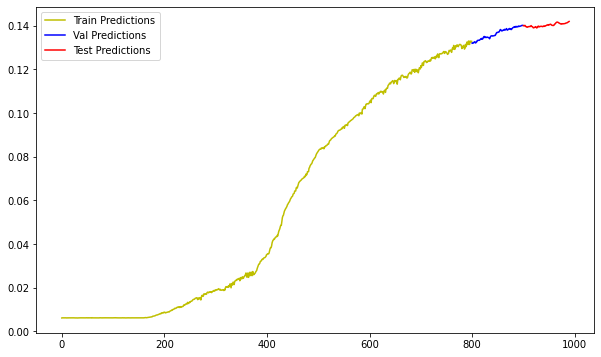

In [66]:
fig = plt.figure(figsize=(10, 6))
train_results['Predictions'].plot(color="y", label='Train Predictions')
val_results['Predictions'].plot(color="b", label='Val Predictions')
test_results['Predictions'].plot(color="r", label='Test Predictions')
plt.legend()

### Calculate RMSE performance metrics:

In [67]:
train_predictions = train_results['Predictions']
forecast_accuracy(train_predictions, y_train1)

{'mape': 0.22092009626149445,
 'me': 0.001975099970586644,
 'mae': 0.002253002875950223,
 'mpe': 0.2168874948701942,
 'rmse': 0.002660264880382582,
 'acf1': 0.38796562346419017,
 'corr': 0.9993024736016423,
 'minmax': 0.13832355146281272}

In [68]:
val_predictions = val_results['Predictions']
forecast_accuracy(val_predictions, y_val1)

{'mape': 0.010355239061589938,
 'me': -0.00016761913895603804,
 'mae': 0.0014115445315837896,
 'mpe': -0.0010594929993640847,
 'rmse': 0.0017413665369995174,
 'acf1': -0.08654400271673748,
 'corr': 0.8256888048163158,
 'minmax': 0.010277044702230453}

In [69]:
test_predictions = test_results['Predictions']
forecast_accuracy(test_predictions, y_test1)

{'mape': 0.007198630325755403,
 'me': -0.00023637827899717048,
 'mae': 0.0010093866123093438,
 'mpe': -0.0016050218002418748,
 'rmse': 0.0012814084439194697,
 'acf1': 0.0589937712138335,
 'corr': 0.4791480647003241,
 'minmax': 0.007159824373531354}

### Combined result:

In [70]:
frames = [train_results, val_results, test_results]
result_uni = pd.concat(frames)
result_uni

,Date,Predictions,Actuals
0,2022-01-22 21:24:29,0.006167,0.003251
1,2022-01-23 04:42:44,0.006224,0.003438
2,2022-01-23 06:01:41,0.006217,0.003545
3,2022-01-23 15:45:21,0.006180,0.003009
4,2022-01-23 16:34:53,0.006222,0.003429
...,...,...,...
985,2023-01-01 15:11:50,0.141286,0.142326
986,2023-01-01 15:15:02,0.141442,0.142479
987,2023-01-01 18:08:58,0.141602,0.142659
988,2023-01-01 19:23:54,0.141742,0.142822


In [71]:
result_uni.index = pd.to_datetime(result_uni['Date'], format='%Y.%m.%d %H:%M:%S')
result_uni

,Date,Predictions,Actuals
Date,,,
2022-01-22 21:24:29,2022-01-22 21:24:29,0.006167,0.003251
2022-01-23 04:42:44,2022-01-23 04:42:44,0.006224,0.003438
2022-01-23 06:01:41,2022-01-23 06:01:41,0.006217,0.003545
2022-01-23 15:45:21,2022-01-23 15:45:21,0.006180,0.003009
2022-01-23 16:34:53,2022-01-23 16:34:53,0.006222,0.003429
...,...,...,...
2023-01-01 15:11:50,2023-01-01 15:11:50,0.141286,0.142326
2023-01-01 15:15:02,2023-01-01 15:15:02,0.141442,0.142479
2023-01-01 18:08:58,2023-01-01 18:08:58,0.141602,0.142659


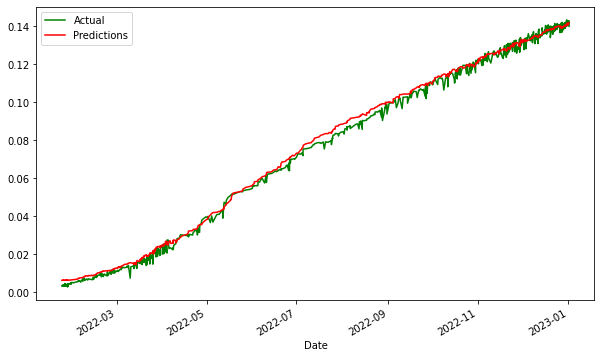

In [72]:
fig = plt.figure(figsize=(10, 6))
result_uni['Actuals'].plot(color="g", label='Actual')
result_uni['Predictions'].plot(color="r", label='Predictions')
plt.legend()

### Prediction of the future values:

In [73]:
past_result=result_uni['Actuals'].tail(50) #last 50 time steps
past_result

Date
2022-12-29 02:24:23    0.141262
2022-12-29 03:01:55    0.139281
2022-12-29 04:01:41    0.141145
2022-12-29 04:13:47    0.140472
2022-12-29 06:21:13    0.140950
2022-12-29 14:51:11    0.140748
2022-12-29 17:32:58    0.140009
2022-12-29 17:37:36    0.141794
2022-12-30 00:47:22    0.138815
2022-12-30 01:46:45    0.141440
2022-12-30 02:30:11    0.140775
2022-12-30 05:33:27    0.141703
2022-12-30 06:33:06    0.140917
2022-12-30 06:58:32    0.139250
2022-12-30 09:30:59    0.139290
2022-12-30 12:27:21    0.139887
2022-12-30 13:46:14    0.140180
2022-12-30 14:53:32    0.140555
2022-12-30 21:56:17    0.139931
2022-12-31 00:05:43    0.142669
2022-12-31 01:36:42    0.142883
2022-12-31 03:34:00    0.141291
2022-12-31 06:13:05    0.143310
2022-12-31 08:22:43    0.142221
2022-12-31 09:12:13    0.142051
2022-12-31 09:45:10    0.141339
2022-12-31 09:57:27    0.141345
2022-12-31 15:26:46    0.140510
2022-12-31 17:28:12    0.140189
2022-12-31 18:20:27    0.141634
2022-12-31 19:12:01    0.140477
202

In [74]:
len(past_result)

50

In [75]:
past_result.shape #Getting the last 50 time steps

(50,)

In [76]:
past_result = past_result.values.reshape(1,-1) 
past_result.shape

(1, 50)

In [77]:
future_inp = list(past_result)   #past results for the future input
future_inp

[array([0.14126219, 0.13928118, 0.14114487, 0.1404722 , 0.14095044,
        0.1407482 , 0.1400094 , 0.14179394, 0.13881503, 0.14144015,
        0.1407752 , 0.14170322, 0.14091678, 0.13924992, 0.13928977,
        0.13988733, 0.14018041, 0.14055529, 0.13993102, 0.1426686 ,
        0.14288335, 0.14129107, 0.14331047, 0.14222127, 0.14205083,
        0.14133881, 0.14134452, 0.14050981, 0.14018908, 0.14163387,
        0.14047718, 0.14085457, 0.14064741, 0.14090085, 0.14275628,
        0.14055198, 0.1405687 , 0.14147224, 0.14108187, 0.14132416,
        0.14135003, 0.14165458, 0.142168  , 0.14141308, 0.14213651,
        0.14232621, 0.14247882, 0.14265892, 0.14282221, 0.13989082])]

In [78]:
#Predicting next 20 time steps data suing the current data
#It will predict in sliding window manner/algorithm with a stride of 1
future_output_uni=[]  #future output in univariate time series
n_steps=50
i=0
while(i<20): #future 20 time steps
    
    if(len(future_inp)>n_steps): # starts counting after last 50 time steps
        past_result = np.array(future_inp[1:])
        past_result=past_result.reshape(1,-1)
        past_result = past_result.reshape((1, n_steps, 1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_inp = future_inp[1:]
        future_output_uni.extend(yhat.tolist())
        i=i+1
    else:
        past_result = past_result.reshape((1, n_steps,1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_output_uni.extend(yhat.tolist())
        i=i+1
    

print(future_output_uni)

[[0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553]]


In [79]:
#Creating a dummy plane to plot graph one after another
plot_act=np.arange(1,51) #last 50 time steps
plot_pred=np.arange(50,70) #future 20 time steps

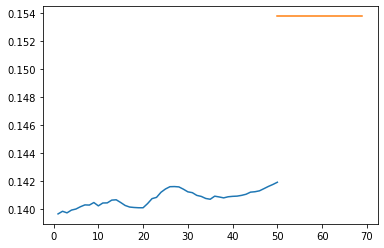

In [80]:
plt.plot(plot_act, result_uni['Predictions'][940:])  #last 50 time steps from total of 990 time steps
plt.plot(plot_pred, future_output_uni)

In [81]:
pred_uni = result_uni['Predictions'].tolist()

In [82]:
len(pred_uni)

990

In [83]:
pred_uni

[0.00616703275591135,
 0.0062241810373961926,
 0.0062166862189769745,
 0.00617951899766922,
 0.00622185692191124,
 0.006216918583959341,
 0.006172450724989176,
 0.006220709066838026,
 0.006229927763342857,
 0.006183438468724489,
 0.0062223998829722404,
 0.006226759869605303,
 0.006176611874252558,
 0.006225625518709421,
 0.0062116156332194805,
 0.0062173414044082165,
 0.006218805909156799,
 0.006225361954420805,
 0.006219028495252132,
 0.006211163010448217,
 0.006219284143298864,
 0.006230953615158796,
 0.006214037537574768,
 0.006227114703506231,
 0.00621331762522459,
 0.006197137758135796,
 0.006194175686687231,
 0.006203263532370329,
 0.006178243085741997,
 0.006203618831932545,
 0.006168582942336798,
 0.00618679029867053,
 0.006191314198076725,
 0.006210417486727238,
 0.006215997971594334,
 0.006222139578312635,
 0.006230892147868872,
 0.006228375248610973,
 0.00620521092787385,
 0.006222906988114119,
 0.006240311078727245,
 0.006217741873115301,
 0.006213453132659197,
 0.006232129

In [84]:
pred_uni_future = [item for sublist in future_output_uni for item in sublist]
pred_uni_future

[0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553]

In [85]:
#Entends helps us to fill the missing value with approx value
pred_uni.extend(pred_uni_future)
print('All Predicted List:', pred_uni)

All Predicted List: [0.00616703275591135, 0.0062241810373961926, 0.0062166862189769745, 0.00617951899766922, 0.00622185692191124, 0.006216918583959341, 0.006172450724989176, 0.006220709066838026, 0.006229927763342857, 0.006183438468724489, 0.0062223998829722404, 0.006226759869605303, 0.006176611874252558, 0.006225625518709421, 0.0062116156332194805, 0.0062173414044082165, 0.006218805909156799, 0.006225361954420805, 0.006219028495252132, 0.006211163010448217, 0.006219284143298864, 0.006230953615158796, 0.006214037537574768, 0.006227114703506231, 0.00621331762522459, 0.006197137758135796, 0.006194175686687231, 0.006203263532370329, 0.006178243085741997, 0.006203618831932545, 0.006168582942336798, 0.00618679029867053, 0.006191314198076725, 0.006210417486727238, 0.006215997971594334, 0.006222139578312635, 0.006230892147868872, 0.006228375248610973, 0.00620521092787385, 0.006222906988114119, 0.006240311078727245, 0.006217741873115301, 0.006213453132659197, 0.006232129409909248, 0.0062021133

In [86]:
len(pred_uni)

1010

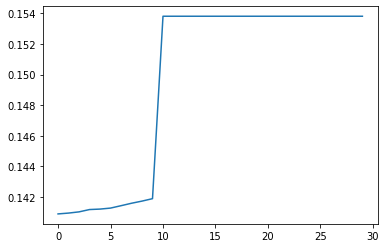

In [87]:
plt.plot(pred_uni[980:]) 

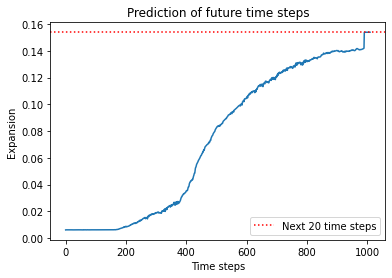

In [88]:
#Plotting final results with predicted value after 20 time steps
plt.plot(pred_uni)
plt.ylabel("Expansion")
plt.xlabel("Time steps")
plt.title("Prediction of future time steps")
plt.axhline(y=pred_uni[len(pred_uni)-1], color = 'red', linestyle = ':', label = 'Next 20 time steps')
plt.legend()

Based on the above analysis, LSTM seems performing better than the CNN for the time-series analysis.

## Forecasting with a Multivariate Time Series

### Preprocessing:

In [89]:
df_multi = pd.DataFrame({'Exp':df_case1['exp']})
df_multi['Seconds'] = df_multi.index.map(pd.Timestamp.timestamp)
df_multi

,Exp,Seconds
Datetime,,
2022-01-22 21:24:29,0.003010,1.642887e+09
2022-01-23 04:42:44,0.003082,1.642913e+09
2022-01-23 06:01:41,0.003201,1.642918e+09
2022-01-23 15:45:21,0.003511,1.642953e+09
2022-01-23 16:34:53,0.003097,1.642956e+09
...,...,...
2023-01-02 03:51:17,0.142326,1.672631e+09
2023-01-02 05:18:53,0.142479,1.672637e+09
2023-01-02 10:52:43,0.142659,1.672657e+09


In [90]:
day = 60*60*24
year = 365.2425*day

df_multi['Day sin'] = np.sin(df_multi['Seconds'] * (2* np.pi / day))
df_multi['Day cos'] = np.cos(df_multi['Seconds'] * (2 * np.pi / day))
df_multi['Year sin'] = np.sin(df_multi['Seconds'] * (2 * np.pi / year))
df_multi['Year cos'] = np.cos(df_multi['Seconds'] * (2 * np.pi / year))
df_multi.head()

,Exp,Seconds,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,,
2022-01-22 21:24:29,0.003010,1.642887e+09,-0.627680,0.778471,0.373994,0.927431
2022-01-23 04:42:44,0.003082,1.642913e+09,0.943705,0.330789,0.378845,0.925460
2022-01-23 06:01:41,0.003201,1.642918e+09,0.999973,-0.007345,0.379718,0.925102
2022-01-23 15:45:21,0.003511,1.642953e+09,-0.832317,-0.554300,0.386159,0.922432
2022-01-23 16:34:53,0.003097,1.642956e+09,-0.931823,-0.362912,0.386705,0.922204


In [91]:
df_multi = df_multi.drop('Seconds', axis=1)
df_multi.head()

,Exp,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,
2022-01-22 21:24:29,0.003010,-0.627680,0.778471,0.373994,0.927431
2022-01-23 04:42:44,0.003082,0.943705,0.330789,0.378845,0.925460
2022-01-23 06:01:41,0.003201,0.999973,-0.007345,0.379718,0.925102
2022-01-23 15:45:21,0.003511,-0.832317,-0.554300,0.386159,0.922432
2022-01-23 16:34:53,0.003097,-0.931823,-0.362912,0.386705,0.922204


In [92]:
df_multi.shape

(1000, 5)

In [93]:
#For a time steps of 5:
# Exp data at different times (t) and daysin (ds) to predict Exp at time 6
# [[[t1, ds1], [t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5]]] [6]
# [[[t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5], [t6, ds6]]] [7] 
# [[[t3, ds3], [t4, ds4], [t5, ds5], [t6, ds6], [t7, ds7]]] [8] 

def df_to_X_y2(df, window_size=Time_steps):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [94]:
X2, y2 = df_to_X_y2(df_multi)
X2.shape, y2.shape

((990, 10, 5), (990,))

In [95]:
X_train2, y_train2 = X2[:A], y2[:A]
X_val2, y_val2 = X2[A:B], y2[A:B]
X_test2, y_test2 = X2[B:], y2[B:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((800, 10, 5), (800,), (100, 10, 5), (100,), (90, 10, 5), (90,))

In [96]:
exp_training_mean = np.mean(X_train2[:, :, 0])
exp_training_std = np.std(X_train2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - exp_training_mean) / exp_training_std
  return X

In [97]:
preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)

array([[[ 1.80623291,  0.95538582,  0.29536068, -0.09704649,
          0.99527985],
        [ 1.86741553,  0.99938063,  0.03519021, -0.09632534,
          0.9953499 ],
        [ 1.829607  ,  0.66756187, -0.74455433, -0.09394036,
          0.99557783],
        ...,
        [ 1.85516475, -0.10011571,  0.9949758 , -0.08365317,
          0.99649493],
        [ 1.84341366,  0.03482682,  0.99939336, -0.08328452,
          0.99652581],
        [ 1.83321971,  0.05444189,  0.99851694, -0.08323095,
          0.99653029]],

       [[ 1.86741553,  0.99938063,  0.03519021, -0.09632534,
          0.9953499 ],
        [ 1.829607  ,  0.66756187, -0.74455433, -0.09394036,
          0.99557783],
        [ 1.85162586, -0.78948596, -0.61376861, -0.08946666,
          0.99598982],
        ...,
        [ 1.84341366,  0.03482682,  0.99939336, -0.08328452,
          0.99652581],
        [ 1.83321971,  0.05444189,  0.99851694, -0.08323095,
          0.99653029],
        [ 1.84511149,  0.22955431,  0.97329585, 

## LSTM Approach

As the previous LSTM results seem good let's use the LSTM approach for the multivariate forecasting.

In [98]:
model3 = Sequential()
model3.add(InputLayer((10, 5))) #window size = (10, 5): time steps = 10, variable of interest = 5 
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [99]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Remember to NOT shuffle the data when training:

In [100]:
model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=150, shuffle =False, callbacks=[cp3])

Epoch 1/150
23/25 [==========================>...] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0528

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 8s 247ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 7.8359e-04 - val_root_mean_squared_error: 0.0280
Epoch 2/150
25/25 [==============================] - 0s 8ms/step - loss: 0.0033 - root_mean_squared_error: 0.0579 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 3/150
25/25 [==============================] - 0s 8ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 4/150
17/25 [===================>..........] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0497

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 5s 224ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 1.1385e-04 - val_root_mean_squared_error: 0.0107
Epoch 5/150
25/25 [==============================] - 0s 11ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 3.7079e-04 - val_root_mean_squared_error: 0.0193
Epoch 6/150
25/25 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 7/150
25/25 [==============================] - 0s 9ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 8/150
25/25 [==============================] - 0s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 9/150
25/25 [==============================] - 0s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0082 - val_root_me

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 5s 202ms/step - loss: 8.5868e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.1066e-04 - val_root_mean_squared_error: 0.0105
Epoch 60/150
25/25 [==============================] - 0s 9ms/step - loss: 4.9493e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.3430e-04 - val_root_mean_squared_error: 0.0116
Epoch 61/150
25/25 [==============================] - 0s 9ms/step - loss: 4.1132e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.5111e-04 - val_root_mean_squared_error: 0.0123
Epoch 62/150
20/25 [=======================>......] - ETA: 0s - loss: 4.8053e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 5s 226ms/step - loss: 4.0633e-05 - root_mean_squared_error: 0.0064 - val_loss: 9.6888e-05 - val_root_mean_squared_error: 0.0098
Epoch 63/150
25/25 [==============================] - 0s 9ms/step - loss: 1.7132e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.4327e-04 - val_root_mean_squared_error: 0.0120
Epoch 64/150
25/25 [==============================] - 0s 9ms/step - loss: 4.2243e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.9665e-04 - val_root_mean_squared_error: 0.0140
Epoch 65/150
25/25 [==============================] - 0s 9ms/step - loss: 1.3120e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.1044e-04 - val_root_mean_squared_error: 0.0105
Epoch 66/150
25/25 [==============================] - 0s 8ms/step - loss: 2.7746e-04 - root_mean_squared_error: 0.0167 - val_loss: 1.7766e-04 - val_root_mean_squared_error: 0.0133
Epoch 67/150
25/25 [==============================] - 0s 9ms/step - loss: 6.6312e-05 - root_mean_squared_error:

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 5s 209ms/step - loss: 3.9865e-05 - root_mean_squared_error: 0.0063 - val_loss: 8.8601e-05 - val_root_mean_squared_error: 0.0094
Epoch 90/150
25/25 [==============================] - 0s 9ms/step - loss: 6.6784e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.0547e-04 - val_root_mean_squared_error: 0.0143
Epoch 91/150
25/25 [==============================] - 0s 8ms/step - loss: 1.8603e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.4747e-04 - val_root_mean_squared_error: 0.0121
Epoch 92/150
25/25 [==============================] - 0s 8ms/step - loss: 1.1770e-04 - root_mean_squared_error: 0.0108 - val_loss: 9.9450e-05 - val_root_mean_squared_error: 0.0100
Epoch 93/150
25/25 [==============================] - 0s 8ms/step - loss: 1.0243e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.9862e-04 - val_root_mean_squared_error: 0.0173
Epoch 94/150
25/25 [==============================] - 0s 8ms/step - loss: 3.1767e-04 - root_mean_squared_error:

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 6s 240ms/step - loss: 6.5686e-06 - root_mean_squared_error: 0.0026 - val_loss: 7.9244e-05 - val_root_mean_squared_error: 0.0089
Epoch 118/150
25/25 [==============================] - 0s 9ms/step - loss: 1.2736e-05 - root_mean_squared_error: 0.0036 - val_loss: 1.1792e-04 - val_root_mean_squared_error: 0.0109
Epoch 119/150
25/25 [==============================] - 0s 9ms/step - loss: 2.1138e-05 - root_mean_squared_error: 0.0046 - val_loss: 9.8127e-05 - val_root_mean_squared_error: 0.0099
Epoch 120/150
22/25 [=========================>....] - ETA: 0s - loss: 1.3474e-05 - root_mean_squared_error: 0.0037

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 5s 210ms/step - loss: 1.2817e-05 - root_mean_squared_error: 0.0036 - val_loss: 6.8250e-05 - val_root_mean_squared_error: 0.0083
Epoch 121/150
25/25 [==============================] - 0s 9ms/step - loss: 2.1519e-05 - root_mean_squared_error: 0.0046 - val_loss: 1.3198e-04 - val_root_mean_squared_error: 0.0115
Epoch 122/150
25/25 [==============================] - 0s 9ms/step - loss: 5.6256e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.0465e-04 - val_root_mean_squared_error: 0.0102
Epoch 123/150
23/25 [==========================>...] - ETA: 0s - loss: 3.5564e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 5s 208ms/step - loss: 3.3429e-05 - root_mean_squared_error: 0.0058 - val_loss: 4.9954e-05 - val_root_mean_squared_error: 0.0071
Epoch 124/150
25/25 [==============================] - 0s 8ms/step - loss: 7.2684e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.9239e-04 - val_root_mean_squared_error: 0.0139
Epoch 125/150
25/25 [==============================] - 0s 9ms/step - loss: 2.1456e-04 - root_mean_squared_error: 0.0146 - val_loss: 1.4439e-04 - val_root_mean_squared_error: 0.0120
Epoch 126/150
25/25 [==============================] - ETA: 0s - loss: 1.2619e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


25/25 [==============================] - 6s 239ms/step - loss: 1.2619e-04 - root_mean_squared_error: 0.0112 - val_loss: 4.6324e-05 - val_root_mean_squared_error: 0.0068
Epoch 127/150
25/25 [==============================] - 0s 9ms/step - loss: 2.2042e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.0623e-04 - val_root_mean_squared_error: 0.0202
Epoch 128/150
25/25 [==============================] - 0s 8ms/step - loss: 5.6425e-04 - root_mean_squared_error: 0.0238 - val_loss: 2.2246e-04 - val_root_mean_squared_error: 0.0149
Epoch 129/150
25/25 [==============================] - 0s 8ms/step - loss: 3.3806e-04 - root_mean_squared_error: 0.0184 - val_loss: 2.0635e-04 - val_root_mean_squared_error: 0.0144
Epoch 130/150
25/25 [==============================] - 0s 10ms/step - loss: 1.6997e-04 - root_mean_squared_error: 0.0130 - val_loss: 5.7635e-04 - val_root_mean_squared_error: 0.0240
Epoch 131/150
25/25 [==============================] - 0s 9ms/step - loss: 1.8924e-04 - root_mean_squared_

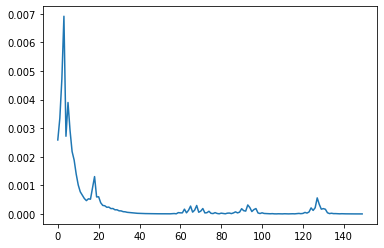

In [101]:
loss_per_epoch = model3.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [102]:
model3 = load_model('model3/')

### Model Evaluation:

,Date,Predictions,Actuals
0,2022-01-22 21:24:29,0.036095,0.003251
1,2022-01-23 04:42:44,0.036071,0.003438
2,2022-01-23 06:01:41,0.036059,0.003545
3,2022-01-23 15:45:21,0.036143,0.003009
4,2022-01-23 16:34:53,0.035883,0.003429
...,...,...,...
795,2022-12-01 14:15:31,0.129113,0.132250
796,2022-12-01 21:17:53,0.130563,0.132081
797,2022-12-02 09:00:42,0.130195,0.127588
798,2022-12-02 12:24:05,0.129490,0.133123


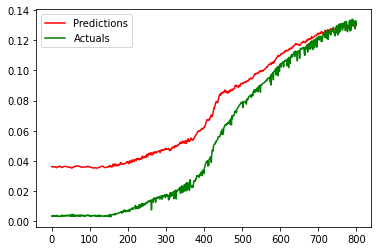

In [103]:
train_results = plot_predictions(model3, X_train2, y_train2, dates1, 0)
train_results.index = pd.RangeIndex(0,0 + len(train_results))
train_results

,Date,Predictions,Actuals
800,2022-12-02 19:08:43,0.129299,0.132992
801,2022-12-02 23:06:07,0.130105,0.130530
802,2022-12-03 01:38:45,0.130563,0.133631
803,2022-12-03 02:37:27,0.130563,0.131681
804,2022-12-03 05:54:57,0.130563,0.133496
...,...,...,...
895,2022-12-25 01:12:34,0.130563,0.141202
896,2022-12-25 04:50:52,0.130563,0.140130
897,2022-12-25 05:31:39,0.130563,0.140514
898,2022-12-25 07:24:30,0.130563,0.139959


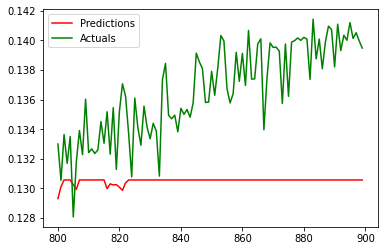

In [104]:
val_results = plot_predictions(model3, X_val2, y_val2, dates2, A)
val_results.index = pd.RangeIndex(A,A + len(val_results))
val_results

,Date,Predictions,Actuals
900,2022-12-26 04:51:17,0.130563,0.140039
901,2022-12-26 05:51:56,0.130563,0.140358
902,2022-12-26 09:12:29,0.130563,0.140753
903,2022-12-26 15:28:33,0.130563,0.136563
904,2022-12-26 16:04:01,0.130563,0.139990
...,...,...,...
985,2023-01-01 15:11:50,0.130563,0.142326
986,2023-01-01 15:15:02,0.130563,0.142479
987,2023-01-01 18:08:58,0.130563,0.142659
988,2023-01-01 19:23:54,0.130563,0.142822


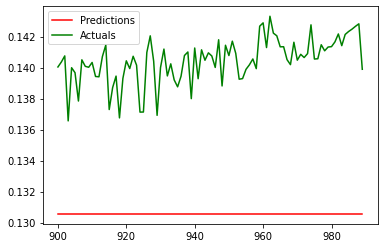

In [105]:
test_results = plot_predictions(model3, X_test2, y_test2, dates3, B)
test_results.index = pd.RangeIndex(B,B + len(test_results))
test_results

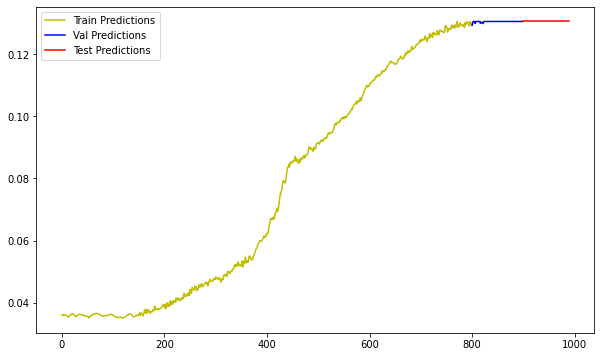

In [106]:
fig = plt.figure(figsize=(10, 6))
train_results['Predictions'].plot(color="y", label='Train Predictions')
val_results['Predictions'].plot(color="b", label='Val Predictions')
test_results['Predictions'].plot(color="r", label='Test Predictions')
plt.legend()

### Calculate RMSE performance metrics:

In [107]:
train_predictions=train_results['Predictions']
forecast_accuracy(train_predictions, y_train2)

{'mape': 2.787860600203446,
 'me': 0.02056233636336406,
 'mae': 0.020747015171218706,
 'mpe': 2.7864579542764636,
 'rmse': 0.024114247995626132,
 'acf1': 0.9837835938361503,
 'corr': 0.9983402638860773,
 'minmax': 0.4417102720993402}

In [108]:
val_predictions=val_results['Predictions']
forecast_accuracy(val_predictions, y_val2)

{'mape': 0.044514189787588754,
 'me': -0.006099780201911895,
 'mae': 0.0061433145403861685,
 'mpe': -0.04417424918067712,
 'rmse': 0.006806165514346448,
 'acf1': 0.6777273789464899,
 'corr': 0.31167496716726384,
 'minmax': 0.04451134908076293}

In [109]:
test_predictions=test_results['Predictions']
forecast_accuracy(test_predictions, y_test2)

{'mape': 0.07025771613216267,
 'me': -0.009880972570843128,
 'mae': 0.009880972570843128,
 'mpe': -0.07025771613216267,
 'rmse': 0.009984243068984747,
 'acf1': 0.3748143170073394,
 'corr': nan,
 'minmax': 0.07025771613216258}

### Combined result:

In [110]:
frames = [train_results, val_results, test_results]
result_multi = pd.concat(frames)
result_multi

,Date,Predictions,Actuals
0,2022-01-22 21:24:29,0.036095,0.003251
1,2022-01-23 04:42:44,0.036071,0.003438
2,2022-01-23 06:01:41,0.036059,0.003545
3,2022-01-23 15:45:21,0.036143,0.003009
4,2022-01-23 16:34:53,0.035883,0.003429
...,...,...,...
985,2023-01-01 15:11:50,0.130563,0.142326
986,2023-01-01 15:15:02,0.130563,0.142479
987,2023-01-01 18:08:58,0.130563,0.142659
988,2023-01-01 19:23:54,0.130563,0.142822


In [111]:
result_multi.index = pd.to_datetime(result_multi['Date'], format='%Y.%m.%d %H:%M:%S')
result_multi

,Date,Predictions,Actuals
Date,,,
2022-01-22 21:24:29,2022-01-22 21:24:29,0.036095,0.003251
2022-01-23 04:42:44,2022-01-23 04:42:44,0.036071,0.003438
2022-01-23 06:01:41,2022-01-23 06:01:41,0.036059,0.003545
2022-01-23 15:45:21,2022-01-23 15:45:21,0.036143,0.003009
2022-01-23 16:34:53,2022-01-23 16:34:53,0.035883,0.003429
...,...,...,...
2023-01-01 15:11:50,2023-01-01 15:11:50,0.130563,0.142326
2023-01-01 15:15:02,2023-01-01 15:15:02,0.130563,0.142479
2023-01-01 18:08:58,2023-01-01 18:08:58,0.130563,0.142659


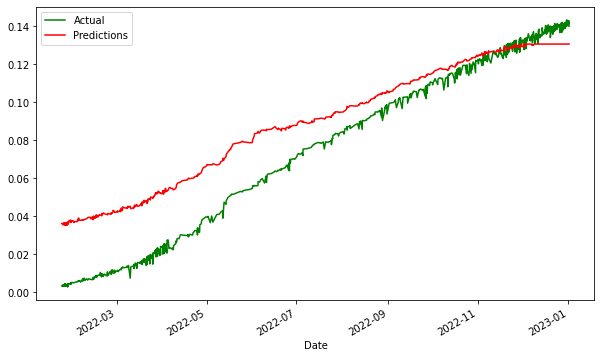

In [112]:
fig = plt.figure(figsize=(10, 6))
result_multi['Actuals'].plot(color="g", label='Actual')
result_multi['Predictions'].plot(color="r", label='Predictions')
plt.legend()

### Prediction of the future values:

In [113]:
past_result=result_multi['Actuals'].tail(50) #last 50 time steps
past_result

Date
2022-12-29 02:24:23    0.141262
2022-12-29 03:01:55    0.139281
2022-12-29 04:01:41    0.141145
2022-12-29 04:13:47    0.140472
2022-12-29 06:21:13    0.140950
2022-12-29 14:51:11    0.140748
2022-12-29 17:32:58    0.140009
2022-12-29 17:37:36    0.141794
2022-12-30 00:47:22    0.138815
2022-12-30 01:46:45    0.141440
2022-12-30 02:30:11    0.140775
2022-12-30 05:33:27    0.141703
2022-12-30 06:33:06    0.140917
2022-12-30 06:58:32    0.139250
2022-12-30 09:30:59    0.139290
2022-12-30 12:27:21    0.139887
2022-12-30 13:46:14    0.140180
2022-12-30 14:53:32    0.140555
2022-12-30 21:56:17    0.139931
2022-12-31 00:05:43    0.142669
2022-12-31 01:36:42    0.142883
2022-12-31 03:34:00    0.141291
2022-12-31 06:13:05    0.143310
2022-12-31 08:22:43    0.142221
2022-12-31 09:12:13    0.142051
2022-12-31 09:45:10    0.141339
2022-12-31 09:57:27    0.141345
2022-12-31 15:26:46    0.140510
2022-12-31 17:28:12    0.140189
2022-12-31 18:20:27    0.141634
2022-12-31 19:12:01    0.140477
202

In [114]:
len(past_result)

50

In [115]:
past_result.shape #Getting the last 50 time steps

(50,)

In [116]:
past_result = past_result.values.reshape(1,-1) 
past_result.shape

(1, 50)

In [117]:
future_inp = list(past_result)   #past results for the future input
future_inp

[array([0.14126219, 0.13928118, 0.14114487, 0.1404722 , 0.14095044,
        0.1407482 , 0.1400094 , 0.14179394, 0.13881503, 0.14144015,
        0.1407752 , 0.14170322, 0.14091678, 0.13924992, 0.13928977,
        0.13988733, 0.14018041, 0.14055529, 0.13993102, 0.1426686 ,
        0.14288335, 0.14129107, 0.14331047, 0.14222127, 0.14205083,
        0.14133881, 0.14134452, 0.14050981, 0.14018908, 0.14163387,
        0.14047718, 0.14085457, 0.14064741, 0.14090085, 0.14275628,
        0.14055198, 0.1405687 , 0.14147224, 0.14108187, 0.14132416,
        0.14135003, 0.14165458, 0.142168  , 0.14141308, 0.14213651,
        0.14232621, 0.14247882, 0.14265892, 0.14282221, 0.13989082])]

In [118]:
#Predicting next 20 time steps data using the current data
#It will predict in sliding window manner/algorithm with a stride of 1
future_output_multi=[]  #future output
n_steps=50
i=0
while(i<20): #future 20 time steps
    
    if(len(future_inp)>n_steps): # starts counting after last 50 time steps
        past_resultp = np.array(future_inp[1:])
        past_result=past_result.reshape(1,-1)
        past_result = past_result.reshape((1, n_steps, 1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_inp = future_inp[1:]
        future_output_multi.extend(yhat.tolist())
        i=i+1
    else:
        past_result = past_result.reshape((1, n_steps,1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_output_multi.extend(yhat.tolist())
        i=i+1
    

print(future_output_multi)

[[0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553]]


In [119]:
#Creating a dummy plane to plot graph one after another
plot_act=np.arange(1,51) #last 50 time steps
plot_pred=np.arange(50,70) #future 20 time steps

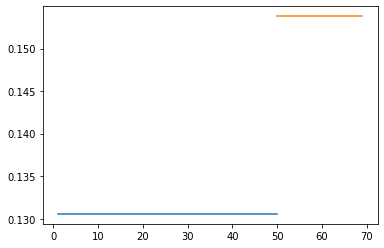

In [120]:
plt.plot(plot_act, result_multi['Predictions'][940:])  #last 10 time steps from total of 990 time steps
plt.plot(plot_pred, future_output_multi)

In [121]:
pred_multi = result_multi['Predictions'].tolist()

In [122]:
len(pred_multi)

990

In [123]:
pred_multi

[0.03609492629766464,
 0.03607103228569031,
 0.03605944663286209,
 0.03614314645528793,
 0.03588268905878067,
 0.03592820465564728,
 0.03603709489107132,
 0.03600732237100601,
 0.03603213280439377,
 0.035964466631412506,
 0.035810686647892,
 0.035748839378356934,
 0.035352617502212524,
 0.03549887239933014,
 0.03559926152229309,
 0.03580097854137421,
 0.03589775413274765,
 0.03594273328781128,
 0.03612703084945679,
 0.03625202178955078,
 0.03643970191478729,
 0.0364227294921875,
 0.036365658044815063,
 0.03618721663951874,
 0.035980224609375,
 0.03578461706638336,
 0.03557777404785156,
 0.035578906536102295,
 0.03569607436656952,
 0.03586043417453766,
 0.03583381325006485,
 0.03599829226732254,
 0.036137908697128296,
 0.03622729331254959,
 0.03627787530422211,
 0.03627626597881317,
 0.03617154061794281,
 0.036099620163440704,
 0.03612689673900604,
 0.03609561175107956,
 0.03602112829685211,
 0.03587514907121658,
 0.0358487144112587,
 0.03591156005859375,
 0.03586752712726593,
 0.035751

In [124]:
pred_multi_future = [item for sublist in future_output_multi for item in sublist]
pred_multi_future

[0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553]

In [125]:
#Entend helps us to fill the missing value with approx value
pred_multi.extend(pred_multi_future)
print('All Predicted List:', pred_multi)

All Predicted List: [0.03609492629766464, 0.03607103228569031, 0.03605944663286209, 0.03614314645528793, 0.03588268905878067, 0.03592820465564728, 0.03603709489107132, 0.03600732237100601, 0.03603213280439377, 0.035964466631412506, 0.035810686647892, 0.035748839378356934, 0.035352617502212524, 0.03549887239933014, 0.03559926152229309, 0.03580097854137421, 0.03589775413274765, 0.03594273328781128, 0.03612703084945679, 0.03625202178955078, 0.03643970191478729, 0.0364227294921875, 0.036365658044815063, 0.03618721663951874, 0.035980224609375, 0.03578461706638336, 0.03557777404785156, 0.035578906536102295, 0.03569607436656952, 0.03586043417453766, 0.03583381325006485, 0.03599829226732254, 0.036137908697128296, 0.03622729331254959, 0.03627787530422211, 0.03627626597881317, 0.03617154061794281, 0.036099620163440704, 0.03612689673900604, 0.03609561175107956, 0.03602112829685211, 0.03587514907121658, 0.0358487144112587, 0.03591156005859375, 0.03586752712726593, 0.03575151413679123, 0.0357961952

In [126]:
len(pred_multi)

1010

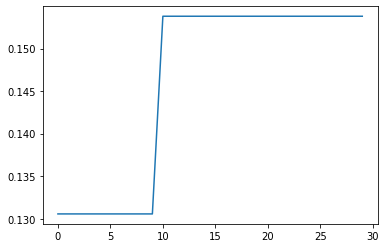

In [127]:
plt.plot(pred_multi[980:]) 

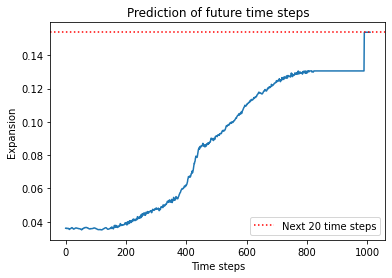

In [128]:
#Plotting final results with predicted value after 20 time steps
plt.plot(pred_multi)
plt.ylabel("Expansion")
plt.xlabel("Time steps")
plt.title("Prediction of future time steps")
plt.axhline(y=pred_multi[len(pred_multi)-1], color = 'red', linestyle = ':', label = 'Next 20 time steps')
plt.legend()

# Case 10: 30 years ASR Expansion with Seasonal Change

## Loading Data for the Model Development

In [129]:
df_case10 = pd.read_csv('data_synthetic_3D')  #Asif_GAN_3D generated data
df_case10.head()

,Datetime,exp,temp
0,2022-01-09 01:50:15,-0.011641,8.965065
1,2022-01-09 08:08:33,-0.012191,9.352649
2,2022-01-09 15:10:37,-0.011879,9.216819
3,2022-01-09 18:44:14,-0.011023,8.856339
4,2022-01-10 19:36:48,-0.011591,9.309155


### Describing the dataset:

In [130]:
print("="*50)
print("First Five Rows ","\n")
print(df_case10.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_case10.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df_case10.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df_case10.isnull().sum(),"\n")

First Five Rows  

              Datetime       exp      temp
0  2022-01-09 01:50:15 -0.011641  8.965065
1  2022-01-09 08:08:33 -0.012191  9.352649 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  1000 non-null   object 
 1   exp       1000 non-null   float64
 2   temp      1000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 23.6+ KB
None 

Describe the Dataset  

               exp         temp
count  1000.000000  1000.000000
mean      0.068114    12.843775
std       0.063729     3.278592
min      -0.020126     5.667081
25%       0.004757    10.201089
50%       0.058389    12.428421
75%       0.126394    15.029362
max       0.261615    25.826780 

Null Values t  

Datetime    0
exp         0
temp        0
dtype: int64 



### Feature engineering:

In [131]:
df_case10.rename(columns={"Exp": "exp", "Temp": "temp"})
df_case10.index = pd.to_datetime(df_case10['Datetime'], format='%Y.%m.%d %H:%M:%S', errors='coerce')
df_case10[:5]

,Datetime,exp,temp
Datetime,,,
2022-01-09 01:50:15,2022-01-09 01:50:15,-0.011641,8.965065
2022-01-09 08:08:33,2022-01-09 08:08:33,-0.012191,9.352649
2022-01-09 15:10:37,2022-01-09 15:10:37,-0.011879,9.216819
2022-01-09 18:44:14,2022-01-09 18:44:14,-0.011023,8.856339
2022-01-10 19:36:48,2022-01-10 19:36:48,-0.011591,9.309155


#### Extracting all Data into Year, Month, Day, Time etc.:

In [132]:
# Extract all Data Like Year Month Day Time etc.
df_case10['Date'] = df_case10.index.date
df_case10['Year'] = df_case10.index.year
df_case10['Month'] = df_case10.index.month
df_case10['Day_of_Month'] = df_case10.index.day
df_case10['Week'] = df_case10.index.week
df_case10['Day'] = df_case10.index.day_name()
df_case10['Time'] = df_case10.index.time
df_case10['Hour'] = df_case10.index.hour
df_case10.head(5)

,Datetime,exp,temp,Date,Year,Month,Day_of_Month,Week,Day,Time,Hour
Datetime,,,,,,,,,,,
2022-01-09 01:50:15,2022-01-09 01:50:15,-0.011641,8.965065,2022-01-09,2022,1,9,1,Sunday,01:50:15,1
2022-01-09 08:08:33,2022-01-09 08:08:33,-0.012191,9.352649,2022-01-09,2022,1,9,1,Sunday,08:08:33,8
2022-01-09 15:10:37,2022-01-09 15:10:37,-0.011879,9.216819,2022-01-09,2022,1,9,1,Sunday,15:10:37,15
2022-01-09 18:44:14,2022-01-09 18:44:14,-0.011023,8.856339,2022-01-09,2022,1,9,1,Sunday,18:44:14,18
2022-01-10 19:36:48,2022-01-10 19:36:48,-0.011591,9.309155,2022-01-10,2022,1,10,2,Monday,19:36:48,19


In [133]:
print(df_case10.Year.unique(),"\n")
print("Total Number of Unique Years", df_case10.Year.nunique(), "\n")

[2022 2023] 

Total Number of Unique Years 2 



#### Exploration:

Let’s start simple at the very beginning. We can have a look at the expansion over the whole time frame again.

In [134]:
df_case10['exp'] 

Datetime
2022-01-09 01:50:15   -0.011641
2022-01-09 08:08:33   -0.012191
2022-01-09 15:10:37   -0.011879
2022-01-09 18:44:14   -0.011023
2022-01-10 19:36:48   -0.011591
                         ...   
2023-02-14 09:38:54    0.184434
2023-03-02 08:55:30    0.192978
2023-03-24 05:03:00    0.192028
2023-03-26 02:33:26    0.256871
2023-04-08 23:28:56    0.261615
Name: exp, Length: 1000, dtype: float64

<AxesSubplot:xlabel='Datetime'>

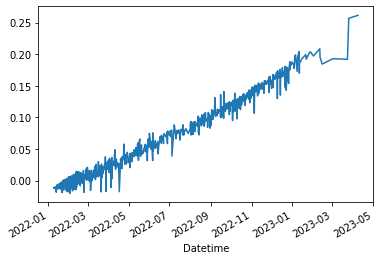

In [135]:
df_case10['exp'].plot()

Expansion is increasing with time.

Let's have a look at the expansion values by month.

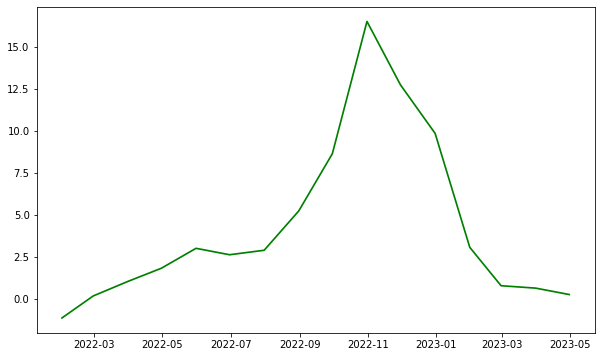

In [136]:
fig = plt.figure(figsize=(10, 6))
df_by_month=df_case10.resample('M').sum()
df_by_month
plt.plot(df_by_month.index,df_by_month['exp'], color="green", linewidth=1.7)

Expansion increases with an increasing rate as the time proceeds to the end of the year.

Let's have a look at the expansion values for different time parameters.

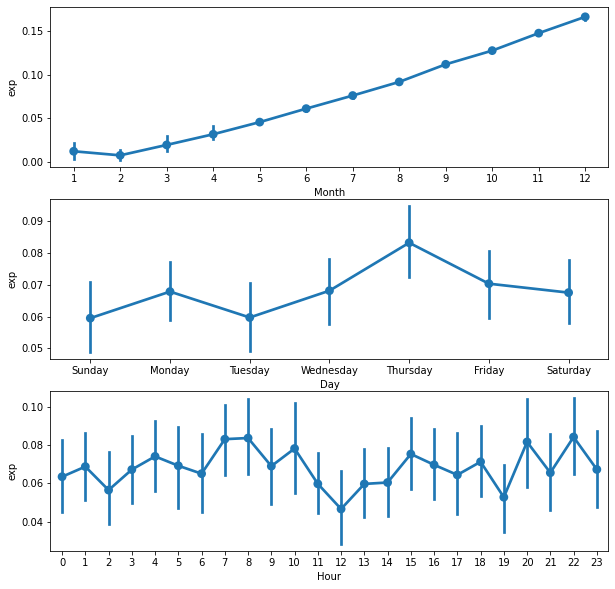

In [137]:
fig = plt.figure(figsize=(10, 10))
ax1= fig.add_subplot(311)
sns.pointplot(data=df_case10, x='Month', y='exp');

ax2= fig.add_subplot(312)
sns.pointplot(data=df_case10, x='Day', y='exp');

ax3= fig.add_subplot(313)
sns.pointplot(data=df_case10, x='Hour', y='exp');

Progression of month has impactr on the expansion values. Days or the hourly progress do not impact that much as the expansion needs long time to show up under the chemical reaction.

Let's see the distribution of the expansion values.

Text(0.5, 1.0, 'Average expansion')

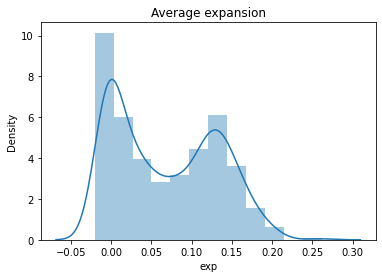

In [138]:
sns.distplot(df_case10["exp"])
plt.title("Average expansion")

The feature engineering seems interesting. The new features separate the data very well.
Let's use the last 70% of the data for training (up to Nov 2022).

In [139]:
Train_percent=0.7
Val_percent=0.15
Test_percent=0.15

In [140]:
A=int(Train_percent*1000)   
B=int(A+Val_percent *1000) 

Let's set the time step based on the visualized data.

In [141]:
Time_steps = 10 #Input=No. of time steps

Let's split the datetimes based on train and test data separation.

In [142]:
dates1=df_case1[:A].index.to_list()
dates2=df_case1[A:B].index.to_list()
dates3=df_case1[B:-Time_steps].index.to_list()
dates3

[Timestamp('2022-12-16 10:43:31'),
 Timestamp('2022-12-16 12:27:06'),
 Timestamp('2022-12-16 14:58:10'),
 Timestamp('2022-12-16 20:02:44'),
 Timestamp('2022-12-17 10:09:47'),
 Timestamp('2022-12-17 10:26:27'),
 Timestamp('2022-12-17 12:18:14'),
 Timestamp('2022-12-17 20:07:47'),
 Timestamp('2022-12-17 23:19:04'),
 Timestamp('2022-12-18 09:48:23'),
 Timestamp('2022-12-18 14:46:00'),
 Timestamp('2022-12-18 16:12:02'),
 Timestamp('2022-12-18 16:16:18'),
 Timestamp('2022-12-19 02:53:04'),
 Timestamp('2022-12-19 03:40:38'),
 Timestamp('2022-12-19 18:04:32'),
 Timestamp('2022-12-19 23:48:16'),
 Timestamp('2022-12-20 02:44:05'),
 Timestamp('2022-12-20 16:42:29'),
 Timestamp('2022-12-20 22:12:18'),
 Timestamp('2022-12-21 00:24:31'),
 Timestamp('2022-12-21 00:37:06'),
 Timestamp('2022-12-21 02:20:37'),
 Timestamp('2022-12-21 19:46:17'),
 Timestamp('2022-12-22 02:12:49'),
 Timestamp('2022-12-22 02:42:53'),
 Timestamp('2022-12-22 11:21:49'),
 Timestamp('2022-12-22 11:53:42'),
 Timestamp('2022-12-

## Forecasting with a Multivariate Time Series

### Preprocessing:

In [143]:
df_multi = pd.DataFrame({'Temp':df_case10['temp']})
df_multi['Seconds'] = df_multi.index.map(pd.Timestamp.timestamp)
df_multi

,Temp,Seconds
Datetime,,
2022-01-09 01:50:15,8.965065,1.641693e+09
2022-01-09 08:08:33,9.352649,1.641716e+09
2022-01-09 15:10:37,9.216819,1.641741e+09
2022-01-09 18:44:14,8.856339,1.641754e+09
2022-01-10 19:36:48,9.309155,1.641843e+09
...,...,...
2023-02-14 09:38:54,21.104151,1.676368e+09
2023-03-02 08:55:30,21.571161,1.677747e+09
2023-03-24 05:03:00,18.816366,1.679634e+09


In [144]:
df_multi = pd.concat([df_case10['exp'], df_multi], axis=1)
df_multi.head()

,exp,Temp,Seconds
Datetime,,,
2022-01-09 01:50:15,-0.011641,8.965065,1.641693e+09
2022-01-09 08:08:33,-0.012191,9.352649,1.641716e+09
2022-01-09 15:10:37,-0.011879,9.216819,1.641741e+09
2022-01-09 18:44:14,-0.011023,8.856339,1.641754e+09
2022-01-10 19:36:48,-0.011591,9.309155,1.641843e+09


In [145]:
day = 60*60*24
year = 365.2425*day

df_multi['Day sin'] = np.sin(df_multi['Seconds'] * (2* np.pi / day))
df_multi['Day cos'] = np.cos(df_multi['Seconds'] * (2 * np.pi / day))
df_multi['Year sin'] = np.sin(df_multi['Seconds'] * (2 * np.pi / year))
df_multi['Year cos'] = np.cos(df_multi['Seconds'] * (2 * np.pi / year))
df_multi.head()

,exp,Temp,Seconds,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,,,
2022-01-09 01:50:15,-0.011641,8.965065,1.641693e+09,0.462716,0.886507,0.145134,0.989412
2022-01-09 08:08:33,-0.012191,9.352649,1.641716e+09,0.846774,-0.531953,0.149604,0.988746
2022-01-09 15:10:37,-0.011879,9.216819,1.641741e+09,-0.739092,-0.673604,0.154587,0.987979
2022-01-09 18:44:14,-0.011023,8.856339,1.641754e+09,-0.981432,0.191808,0.157108,0.987581
2022-01-10 19:36:48,-0.011591,9.309155,1.641843e+09,-0.912120,0.409923,0.174692,0.984623


In [146]:
df_multi = df_multi.drop('Seconds', axis=1)
df_multi.head()

,exp,Temp,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,,
2022-01-09 01:50:15,-0.011641,8.965065,0.462716,0.886507,0.145134,0.989412
2022-01-09 08:08:33,-0.012191,9.352649,0.846774,-0.531953,0.149604,0.988746
2022-01-09 15:10:37,-0.011879,9.216819,-0.739092,-0.673604,0.154587,0.987979
2022-01-09 18:44:14,-0.011023,8.856339,-0.981432,0.191808,0.157108,0.987581
2022-01-10 19:36:48,-0.011591,9.309155,-0.912120,0.409923,0.174692,0.984623


In [147]:
df_multi.shape

(1000, 6)

In [148]:
#For a time steps of 5:
# Temp data at different times (t) and daysin (ds) to predict Temp at time 6
# [[[t1, ds1], [t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5]]] [6]
# [[[t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5], [t6, ds6]]] [7] 
# [[[t3, ds3], [t4, ds4], [t5, ds5], [t6, ds6], [t7, ds7]]] [8] 

def df_to_X_y3(df, window_size=Time_steps):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [149]:
X3, y3 = df_to_X_y3(df_multi)
X3.shape, y3.shape

((990, 10, 6), (990, 2))

In [150]:
X_train3, y_train3 = X3[:A], y3[:A]
X_val3, y_val3 = X3[A:B], y3[A:B]
X_test3, y_test3 = X3[B:], y3[B:]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((700, 10, 6), (700, 2), (150, 10, 6), (150, 2), (140, 10, 6), (140, 2))

In [151]:
exp_training_mean = np.mean(X_train3[:, :, 0])
exp_training_std = np.std(X_train3[:, :, 0])

temp_training_mean = np.mean(X_train3[:, :, 1])
temp_training_std = np.std(X_train3[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - exp_training_mean) / exp_training_std
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean) / temp_training_std

def preprocess_output(y):
  y[:, 0] = (y[:, 0] - exp_training_mean) / exp_training_std
  y[:, 1] = (y[:, 1] - temp_training_mean) / temp_training_std
  return y

In [152]:
preprocess(X_train3)
preprocess(X_val3)
preprocess(X_test3)

In [153]:
preprocess_output(y_train3)
preprocess_output(y_val3)
preprocess_output(y_test3)

array([[2.73218474, 2.92840293],
       [2.5396885 , 2.46313438],
       [2.54552317, 2.89496673],
       [2.49553031, 2.34171422],
       [2.55866419, 2.35591374],
       [2.33189577, 3.48439515],
       [2.70727871, 2.64659986],
       [2.64732105, 2.80375751],
       [2.45112028, 2.30111504],
       [2.73744185, 2.63488335],
       [2.7236276 , 2.51486165],
       [2.62919094, 2.86021908],
       [2.81793482, 3.15554046],
       [2.42387728, 2.60564013],
       [2.63925635, 3.04203563],
       [2.7496782 , 2.53089807],
       [2.68087427, 2.71293769],
       [2.55396494, 2.60396909],
       [2.77672985, 2.62405043],
       [2.70971979, 2.5868164 ],
       [2.73087486, 2.92972688],
       [2.76620929, 3.05413866],
       [2.59793952, 3.28407023],
       [2.6941194 , 2.97049239],
       [2.83268189, 2.70969656],
       [2.69628471, 2.92927979],
       [2.58856704, 2.43733132],
       [2.67261822, 2.97393447],
       [2.74402714, 3.14972835],
       [2.77875095, 2.76953001],
       [2.

## LSTM Approach

As the previous LSTM results seem good let's use the LSTM approach for the multivariate forecasting.

In [154]:
model4 = Sequential()
model4.add(InputLayer((10, 6)))   #window size = (10, 6): time steps = 10, variable of interest = 6 

model4.add(LSTM(32, return_sequences=True))  #making it a little bit of complex for the multivariate purposes

model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(2, 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 32)            4992      
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
Total params: 30,362
Trainable params: 30,362
Non-trainable params: 0
_________________________________________________________________


In [155]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Remember to NOT shuffle the data when training:

In [156]:
model4.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=150, shuffle =False, callbacks=[cp4])

Epoch 1/150
21/22 [===========================>..] - ETA: 0s - loss: 0.6571 - root_mean_squared_error: 0.8106

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 15s 499ms/step - loss: 0.6912 - root_mean_squared_error: 0.8314 - val_loss: 2.1914 - val_root_mean_squared_error: 1.4803
Epoch 2/150
21/22 [===========================>..] - ETA: 0s - loss: 0.2858 - root_mean_squared_error: 0.5346

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 478ms/step - loss: 0.2853 - root_mean_squared_error: 0.5341 - val_loss: 0.8387 - val_root_mean_squared_error: 0.9158
Epoch 3/150
21/22 [===========================>..] - ETA: 0s - loss: 0.1705 - root_mean_squared_error: 0.4129

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 13s 613ms/step - loss: 0.1734 - root_mean_squared_error: 0.4164 - val_loss: 0.6204 - val_root_mean_squared_error: 0.7877
Epoch 4/150
22/22 [==============================] - ETA: 0s - loss: 0.2088 - root_mean_squared_error: 0.4570

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 11s 542ms/step - loss: 0.2088 - root_mean_squared_error: 0.4570 - val_loss: 0.3814 - val_root_mean_squared_error: 0.6176
Epoch 5/150
22/22 [==============================] - 0s 19ms/step - loss: 0.1939 - root_mean_squared_error: 0.4403 - val_loss: 0.6964 - val_root_mean_squared_error: 0.8345
Epoch 6/150
19/22 [========================>.....] - ETA: 0s - loss: 0.1722 - root_mean_squared_error: 0.4150

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 11s 510ms/step - loss: 0.1623 - root_mean_squared_error: 0.4029 - val_loss: 0.3026 - val_root_mean_squared_error: 0.5501
Epoch 7/150
22/22 [==============================] - 0s 21ms/step - loss: 0.1619 - root_mean_squared_error: 0.4024 - val_loss: 0.6470 - val_root_mean_squared_error: 0.8044
Epoch 8/150
20/22 [==========================>...] - ETA: 0s - loss: 0.1442 - root_mean_squared_error: 0.3797

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 467ms/step - loss: 0.1368 - root_mean_squared_error: 0.3698 - val_loss: 0.2659 - val_root_mean_squared_error: 0.5156
Epoch 9/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1270 - root_mean_squared_error: 0.3564 - val_loss: 0.4351 - val_root_mean_squared_error: 0.6596
Epoch 10/150
21/22 [===========================>..] - ETA: 0s - loss: 0.1335 - root_mean_squared_error: 0.3654

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 489ms/step - loss: 0.1299 - root_mean_squared_error: 0.3605 - val_loss: 0.2652 - val_root_mean_squared_error: 0.5150
Epoch 11/150
22/22 [==============================] - 0s 18ms/step - loss: 0.1232 - root_mean_squared_error: 0.3510 - val_loss: 0.3579 - val_root_mean_squared_error: 0.5982
Epoch 12/150
22/22 [==============================] - ETA: 0s - loss: 0.1303 - root_mean_squared_error: 0.3610

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 475ms/step - loss: 0.1303 - root_mean_squared_error: 0.3610 - val_loss: 0.2600 - val_root_mean_squared_error: 0.5099
Epoch 13/150
22/22 [==============================] - 0s 18ms/step - loss: 0.1245 - root_mean_squared_error: 0.3529 - val_loss: 0.3325 - val_root_mean_squared_error: 0.5766
Epoch 14/150
21/22 [===========================>..] - ETA: 0s - loss: 0.1363 - root_mean_squared_error: 0.3692

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 483ms/step - loss: 0.1326 - root_mean_squared_error: 0.3642 - val_loss: 0.2531 - val_root_mean_squared_error: 0.5031
Epoch 15/150
22/22 [==============================] - 0s 20ms/step - loss: 0.1313 - root_mean_squared_error: 0.3624 - val_loss: 0.3550 - val_root_mean_squared_error: 0.5958
Epoch 16/150
20/22 [==========================>...] - ETA: 0s - loss: 0.1444 - root_mean_squared_error: 0.3800

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 455ms/step - loss: 0.1371 - root_mean_squared_error: 0.3703 - val_loss: 0.2507 - val_root_mean_squared_error: 0.5007
Epoch 17/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1444 - root_mean_squared_error: 0.3800 - val_loss: 0.4397 - val_root_mean_squared_error: 0.6631
Epoch 18/150
22/22 [==============================] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3732

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 480ms/step - loss: 0.1393 - root_mean_squared_error: 0.3732 - val_loss: 0.2501 - val_root_mean_squared_error: 0.5001
Epoch 19/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1438 - root_mean_squared_error: 0.3792 - val_loss: 0.4824 - val_root_mean_squared_error: 0.6945
Epoch 20/150
22/22 [==============================] - ETA: 0s - loss: 0.1329 - root_mean_squared_error: 0.3645

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 464ms/step - loss: 0.1329 - root_mean_squared_error: 0.3645 - val_loss: 0.2485 - val_root_mean_squared_error: 0.4985
Epoch 21/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1291 - root_mean_squared_error: 0.3593 - val_loss: 0.4144 - val_root_mean_squared_error: 0.6437
Epoch 22/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1234 - root_mean_squared_error: 0.3512 - val_loss: 0.2538 - val_root_mean_squared_error: 0.5038
Epoch 23/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1172 - root_mean_squared_error: 0.3424 - val_loss: 0.3421 - val_root_mean_squared_error: 0.5849
Epoch 24/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1182 - root_mean_squared_error: 0.3439 - val_loss: 0.2506 - val_root_mean_squared_error: 0.5006
Epoch 25/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1159 - root_mean_squared_error: 0.3405 - val_loss: 0.2972 - val_root_

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 9s 436ms/step - loss: 0.1175 - root_mean_squared_error: 0.3428 - val_loss: 0.2456 - val_root_mean_squared_error: 0.4955
Epoch 27/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1130 - root_mean_squared_error: 0.3361 - val_loss: 0.2653 - val_root_mean_squared_error: 0.5150
Epoch 28/150
19/22 [========================>.....] - ETA: 0s - loss: 0.1230 - root_mean_squared_error: 0.3507

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 11s 516ms/step - loss: 0.1149 - root_mean_squared_error: 0.3390 - val_loss: 0.2350 - val_root_mean_squared_error: 0.4848
Epoch 29/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.2471 - val_root_mean_squared_error: 0.4971
Epoch 30/150
19/22 [========================>.....] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3504

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 460ms/step - loss: 0.1147 - root_mean_squared_error: 0.3386 - val_loss: 0.2256 - val_root_mean_squared_error: 0.4750
Epoch 31/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1128 - root_mean_squared_error: 0.3359 - val_loss: 0.2342 - val_root_mean_squared_error: 0.4840
Epoch 32/150
21/22 [===========================>..] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3450

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 9s 434ms/step - loss: 0.1160 - root_mean_squared_error: 0.3406 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4663
Epoch 33/150
22/22 [==============================] - 1s 30ms/step - loss: 0.1144 - root_mean_squared_error: 0.3383 - val_loss: 0.2287 - val_root_mean_squared_error: 0.4782
Epoch 34/150
22/22 [==============================] - ETA: 0s - loss: 0.1214 - root_mean_squared_error: 0.3484

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 491ms/step - loss: 0.1214 - root_mean_squared_error: 0.3484 - val_loss: 0.2086 - val_root_mean_squared_error: 0.4567
Epoch 35/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1224 - root_mean_squared_error: 0.3499 - val_loss: 0.2454 - val_root_mean_squared_error: 0.4954
Epoch 36/150
19/22 [========================>.....] - ETA: 0s - loss: 0.1421 - root_mean_squared_error: 0.3769

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 464ms/step - loss: 0.1331 - root_mean_squared_error: 0.3649 - val_loss: 0.2061 - val_root_mean_squared_error: 0.4540
Epoch 37/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1356 - root_mean_squared_error: 0.3682 - val_loss: 0.2985 - val_root_mean_squared_error: 0.5463
Epoch 38/150
22/22 [==============================] - 0s 14ms/step - loss: 0.1524 - root_mean_squared_error: 0.3904 - val_loss: 0.2170 - val_root_mean_squared_error: 0.4658
Epoch 39/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1663 - root_mean_squared_error: 0.4078 - val_loss: 0.3454 - val_root_mean_squared_error: 0.5877
Epoch 40/150
22/22 [==============================] - 0s 15ms/step - loss: 0.2054 - root_mean_squared_error: 0.4533 - val_loss: 0.3372 - val_root_mean_squared_error: 0.5807
Epoch 41/150
22/22 [==============================] - 0s 15ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861 - val_loss: 0.6246 - val_root_

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 485ms/step - loss: 0.1042 - root_mean_squared_error: 0.3227 - val_loss: 0.2043 - val_root_mean_squared_error: 0.4520
Epoch 56/150
22/22 [==============================] - 0s 19ms/step - loss: 0.1041 - root_mean_squared_error: 0.3227 - val_loss: 0.2141 - val_root_mean_squared_error: 0.4628
Epoch 57/150
22/22 [==============================] - ETA: 0s - loss: 0.1039 - root_mean_squared_error: 0.3223

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 480ms/step - loss: 0.1039 - root_mean_squared_error: 0.3223 - val_loss: 0.1939 - val_root_mean_squared_error: 0.4403
Epoch 58/150
22/22 [==============================] - 0s 18ms/step - loss: 0.1040 - root_mean_squared_error: 0.3225 - val_loss: 0.2107 - val_root_mean_squared_error: 0.4590
Epoch 59/150
21/22 [===========================>..] - ETA: 0s - loss: 0.1065 - root_mean_squared_error: 0.3264

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 498ms/step - loss: 0.1040 - root_mean_squared_error: 0.3224 - val_loss: 0.1844 - val_root_mean_squared_error: 0.4294
Epoch 60/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1044 - root_mean_squared_error: 0.3231 - val_loss: 0.2144 - val_root_mean_squared_error: 0.4631
Epoch 61/150
19/22 [========================>.....] - ETA: 0s - loss: 0.1117 - root_mean_squared_error: 0.3341

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 475ms/step - loss: 0.1048 - root_mean_squared_error: 0.3238 - val_loss: 0.1760 - val_root_mean_squared_error: 0.4196
Epoch 62/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1060 - root_mean_squared_error: 0.3256 - val_loss: 0.2274 - val_root_mean_squared_error: 0.4769
Epoch 63/150
21/22 [===========================>..] - ETA: 0s - loss: 0.1095 - root_mean_squared_error: 0.3310

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 9s 439ms/step - loss: 0.1070 - root_mean_squared_error: 0.3271 - val_loss: 0.1740 - val_root_mean_squared_error: 0.4172
Epoch 64/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1104 - root_mean_squared_error: 0.3322 - val_loss: 0.2434 - val_root_mean_squared_error: 0.4933
Epoch 65/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.1833 - val_root_mean_squared_error: 0.4281
Epoch 66/150
22/22 [==============================] - 0s 18ms/step - loss: 0.1200 - root_mean_squared_error: 0.3464 - val_loss: 0.2223 - val_root_mean_squared_error: 0.4714
Epoch 67/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1261 - root_mean_squared_error: 0.3550 - val_loss: 0.1926 - val_root_mean_squared_error: 0.4389
Epoch 68/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1197 - root_mean_squared_error: 0.3460 - val_loss: 0.1988 - val_root_m

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


22/22 [==============================] - 10s 493ms/step - loss: 0.1070 - root_mean_squared_error: 0.3271 - val_loss: 0.1691 - val_root_mean_squared_error: 0.4112
Epoch 73/150
22/22 [==============================] - 0s 14ms/step - loss: 0.1099 - root_mean_squared_error: 0.3315 - val_loss: 0.2474 - val_root_mean_squared_error: 0.4974
Epoch 74/150
22/22 [==============================] - 0s 15ms/step - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1720 - val_root_mean_squared_error: 0.4147
Epoch 75/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1260 - root_mean_squared_error: 0.3550 - val_loss: 0.3664 - val_root_mean_squared_error: 0.6053
Epoch 76/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1208 - root_mean_squared_error: 0.3476 - val_loss: 0.1917 - val_root_mean_squared_error: 0.4378
Epoch 77/150
22/22 [==============================] - 0s 16ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 0.4034 - val_root_

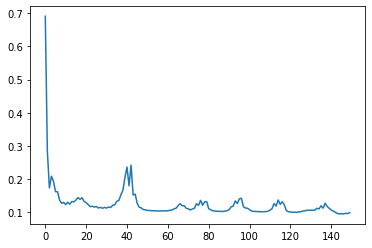

In [157]:
loss_per_epoch = model4.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [158]:
model4 = load_model('model4/')

### Model Evaluation:

In [159]:
#postprocess to get the function in real values
def postprocess_exp(arr):
  arr = (arr*exp_training_std) + exp_training_mean
  return arr

def postprocess_temp(arr):
  arr = (arr*temp_training_std) + temp_training_mean
  return arr

In [160]:
def plot_predictions2(model, X, y, dates, range, start=0, end=1000):
  predictions = model.predict(X)
  exp_preds, temp_preds = postprocess_exp(predictions[:, 0]), postprocess_temp(predictions[:, 1])
  exp_actuals, temp_actuals = postprocess_exp(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Date':dates,
                          'Exp Predictions': exp_preds,
                          'Exp Actuals':exp_actuals,
                          'Temp Predictions': temp_preds,
                          'Temp Actuals': temp_actuals
                          })
  df.index = pd.RangeIndex(range,range + len(df))
  fig = plt.figure(figsize=(10, 10))
  ax1= fig.add_subplot(211)
  plt.plot(df['Exp Predictions'][start:end])
  plt.plot(df['Exp Actuals'][start:end])
  ax2= fig.add_subplot(212)
  plt.plot(df['Temp Predictions'][start:end])
  plt.plot(df['Temp Actuals'][start:end])
  return df

,Date,Exp Predictions,Exp Actuals,Temp Predictions,Temp Actuals
0,2022-01-22 21:24:29,-0.003019,-0.010939,9.282042,9.363324
1,2022-01-23 04:42:44,-0.003041,-0.014421,9.237913,9.256897
2,2022-01-23 06:01:41,-0.002818,-0.009808,9.196636,8.848516
3,2022-01-23 15:45:21,-0.002456,-0.018281,9.141762,9.554899
4,2022-01-23 16:34:53,-0.002992,-0.012169,9.187976,9.552373
...,...,...,...,...,...
695,2022-10-29 08:37:25,0.120220,0.124719,14.636005,14.056191
696,2022-10-30 10:00:51,0.120713,0.095128,14.658802,16.192011
697,2022-10-30 12:52:43,0.121274,0.124688,14.681814,14.741401
698,2022-10-31 00:22:00,0.121267,0.121887,14.668831,13.966020


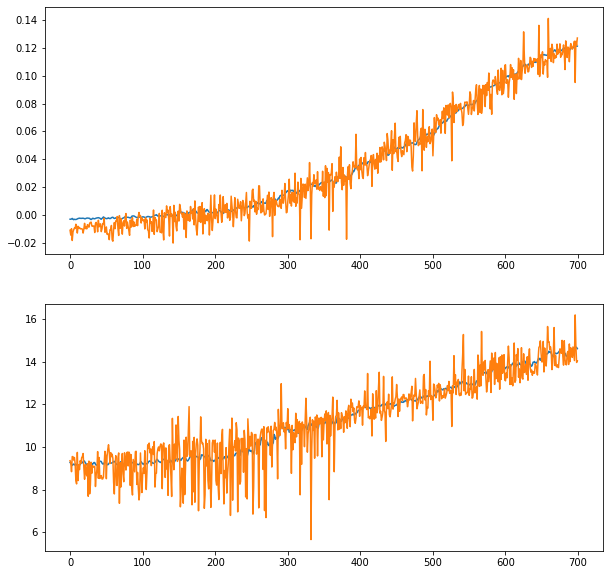

In [161]:
train_results = plot_predictions2(model4, X_train3, y_train3, dates1, 0)
train_results.index = pd.RangeIndex(0,0 + len(train_results))
train_results

,Date,Exp Predictions,Exp Actuals,Temp Predictions,Temp Actuals
700,2022-10-31 21:25:39,0.121406,0.107946,14.572114,15.038285
701,2022-11-01 00:51:29,0.121539,0.120935,14.524322,14.500937
702,2022-11-01 09:43:26,0.121469,0.115547,14.543947,15.401781
703,2022-11-01 09:58:24,0.122296,0.124319,14.529341,14.086635
704,2022-11-02 03:03:39,0.121848,0.120069,14.531769,15.387548
...,...,...,...,...,...
845,2022-12-14 13:34:31,0.125985,0.150767,14.753526,17.380953
846,2022-12-14 17:00:09,0.126422,0.143367,14.765705,16.391348
847,2022-12-14 17:10:18,0.126604,0.147058,14.771204,15.783744
848,2022-12-15 08:01:20,0.126675,0.147957,14.768263,16.133450


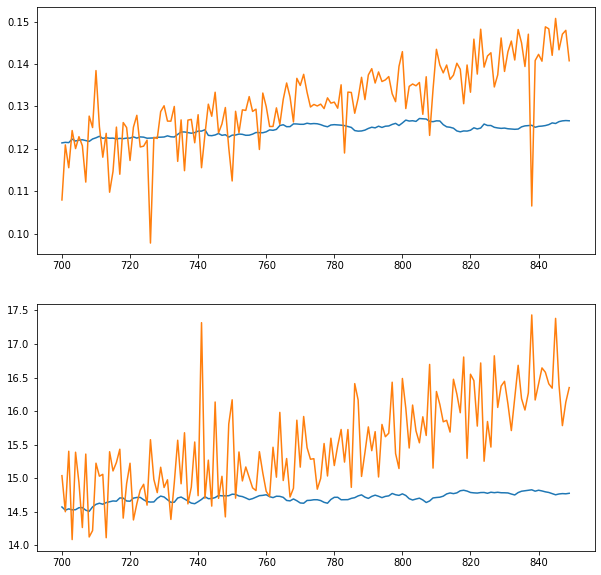

In [162]:
val_results = plot_predictions2(model4, X_val3, y_val3, dates2, A)
val_results.index = pd.RangeIndex(A,A + len(val_results))
val_results

,Date,Exp Predictions,Exp Actuals,Temp Predictions,Temp Actuals
850,2022-12-16 10:43:31,0.126195,0.150961,14.769719,16.981531
851,2022-12-16 12:27:06,0.126424,0.142806,14.771765,16.058542
852,2022-12-16 14:58:10,0.125527,0.143053,14.762736,16.915201
853,2022-12-16 20:02:44,0.125397,0.140935,14.774936,15.817672
854,2022-12-17 10:09:47,0.124955,0.143610,14.789974,15.845840
...,...,...,...,...,...
985,2023-01-01 15:11:50,0.122668,0.184434,14.752010,21.104151
986,2023-01-01 15:15:02,0.122841,0.192978,14.739989,21.571161
987,2023-01-01 18:08:58,0.122425,0.192028,14.707332,18.816366
988,2023-01-01 19:23:54,0.120785,0.256871,14.652683,25.826780


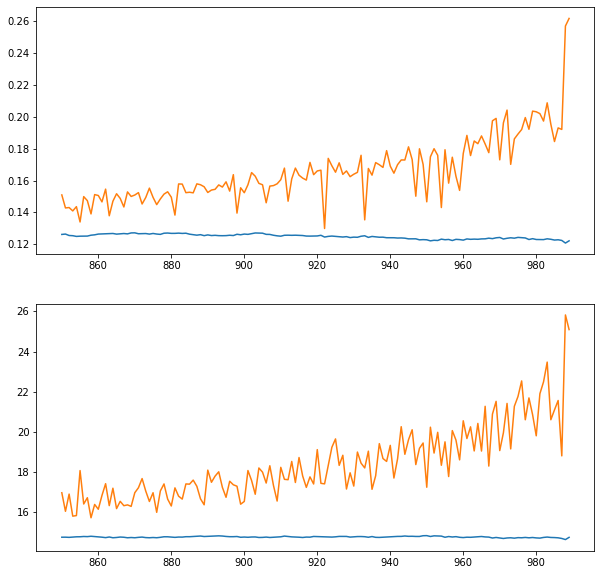

In [163]:
test_results = plot_predictions2(model4, X_test3, y_test3, dates3, B)
test_results.index = pd.RangeIndex(B,B + len(test_results))
test_results

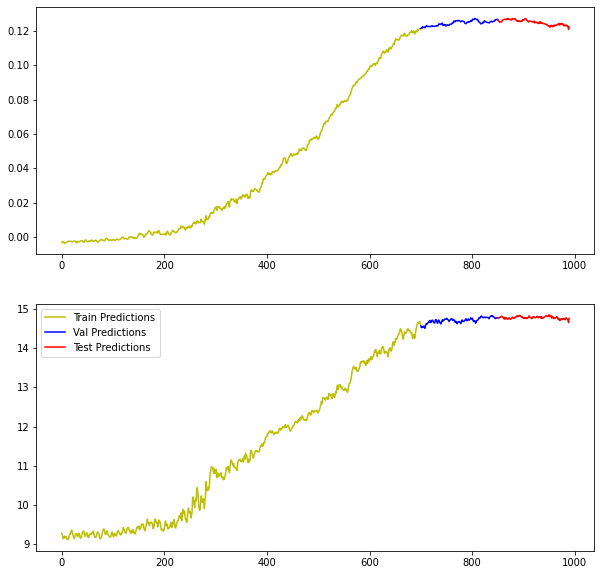

In [164]:
fig = plt.figure(figsize=(10, 10))
ax1= fig.add_subplot(211)
train_results['Exp Predictions'].plot(color="y", label='Train Predictions')
val_results['Exp Predictions'].plot(color="b", label='Val Predictions')
test_results['Exp Predictions'].plot(color="r", label='Test Predictions')
ax2= fig.add_subplot(212)
train_results['Temp Predictions'].plot(color="y", label='Train Predictions')
val_results['Temp Predictions'].plot(color="b", label='Val Predictions')
test_results['Temp Predictions'].plot(color="r", label='Test Predictions')
plt.legend()

### Calculate RMSE performance metrics:

In [165]:
forecast_accuracy(train_results['Exp Predictions'], train_results['Exp Actuals'])

{'mape': 813.0171109566409,
 'me': 0.0019560005835124617,
 'mae': 0.00600108421806777,
 'mpe': -812.3468610418929,
 'rmse': 0.00808418633433507,
 'acf1': 0.014742348302090967,
 'corr': 0.9835466863684987,
 'minmax': -1.3967870271158724}

In [166]:
forecast_accuracy(train_results['Temp Predictions'], train_results['Temp Actuals'])

{'mape': 0.06032455841632631,
 'me': 0.07787822519029892,
 'mae': 0.6000859785079956,
 'mpe': 0.01522333524624104,
 'rmse': 0.8289515470212044,
 'acf1': -0.009923363296966161,
 'corr': 0.910829202407144,
 'minmax': 0.05453053148633413}

In [167]:
forecast_accuracy(val_results['Exp Predictions'], val_results['Exp Actuals'])

{'mape': 0.06685344496286175,
 'me': -0.006622273574272754,
 'mae': 0.008963199009497939,
 'mpe': -0.045774738999621624,
 'rmse': 0.010939383879606966,
 'acf1': 0.4941641583435608,
 'corr': 0.6207233022348181,
 'minmax': 0.06581769689020578}

In [168]:
forecast_accuracy(val_results['Temp Predictions'], val_results['Temp Actuals'])

{'mape': 0.05266374426342267,
 'me': -0.791746826171875,
 'mae': 0.8402188873291015,
 'mpe': -0.04927145888110485,
 'rmse': 1.0335103366442988,
 'acf1': 0.34033181109252864,
 'corr': 0.5736000561537381,
 'minmax': 0.05262470815067222}

In [169]:
forecast_accuracy(test_results['Exp Predictions'], test_results['Exp Actuals'])

{'mape': 0.2353911825150801,
 'me': -0.04079939217439715,
 'mae': 0.04079939217439715,
 'mpe': -0.2353911825150801,
 'rmse': 0.04611262623244867,
 'acf1': 0.7156278009400712,
 'corr': -0.7070157774245186,
 'minmax': 0.23539118251508007}

In [170]:
forecast_accuracy(test_results['Temp Predictions'], test_results['Temp Actuals'])

{'mape': 0.18977490492588328,
 'me': -3.6303016866956437,
 'mae': 3.6303016866956437,
 'mpe': -0.18977490492588328,
 'rmse': 4.076597766189175,
 'acf1': 0.6989674649760875,
 'corr': -0.3467538790903462,
 'minmax': 0.18977490492588323}

### Combined result:

In [171]:
frames = [train_results, val_results, test_results]
result_multi = pd.concat(frames)
result_multi

,Date,Exp Predictions,Exp Actuals,Temp Predictions,Temp Actuals
0,2022-01-22 21:24:29,-0.003019,-0.010939,9.282042,9.363324
1,2022-01-23 04:42:44,-0.003041,-0.014421,9.237913,9.256897
2,2022-01-23 06:01:41,-0.002818,-0.009808,9.196636,8.848516
3,2022-01-23 15:45:21,-0.002456,-0.018281,9.141762,9.554899
4,2022-01-23 16:34:53,-0.002992,-0.012169,9.187976,9.552373
...,...,...,...,...,...
985,2023-01-01 15:11:50,0.122668,0.184434,14.752010,21.104151
986,2023-01-01 15:15:02,0.122841,0.192978,14.739989,21.571161
987,2023-01-01 18:08:58,0.122425,0.192028,14.707332,18.816366
988,2023-01-01 19:23:54,0.120785,0.256871,14.652683,25.826780


In [172]:
result_multi.index = pd.to_datetime(result_multi['Date'], format='%Y.%m.%d %H:%M:%S')
result_multi

,Date,Exp Predictions,Exp Actuals,Temp Predictions,Temp Actuals
Date,,,,,
2022-01-22 21:24:29,2022-01-22 21:24:29,-0.003019,-0.010939,9.282042,9.363324
2022-01-23 04:42:44,2022-01-23 04:42:44,-0.003041,-0.014421,9.237913,9.256897
2022-01-23 06:01:41,2022-01-23 06:01:41,-0.002818,-0.009808,9.196636,8.848516
2022-01-23 15:45:21,2022-01-23 15:45:21,-0.002456,-0.018281,9.141762,9.554899
2022-01-23 16:34:53,2022-01-23 16:34:53,-0.002992,-0.012169,9.187976,9.552373
...,...,...,...,...,...
2023-01-01 15:11:50,2023-01-01 15:11:50,0.122668,0.184434,14.752010,21.104151
2023-01-01 15:15:02,2023-01-01 15:15:02,0.122841,0.192978,14.739989,21.571161
2023-01-01 18:08:58,2023-01-01 18:08:58,0.122425,0.192028,14.707332,18.816366


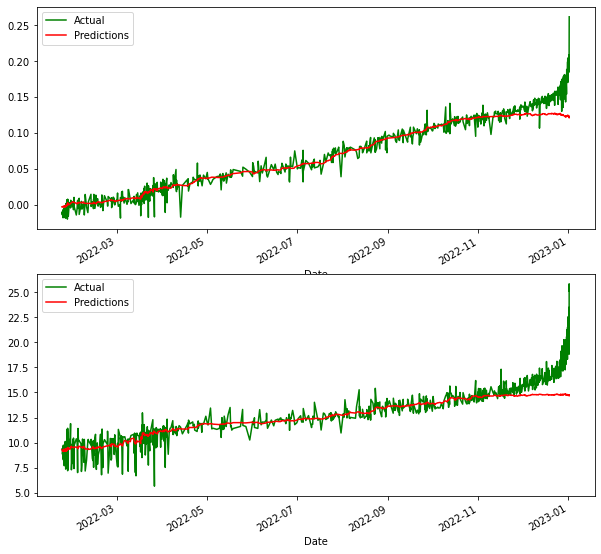

In [173]:
fig = plt.figure(figsize=(10, 10))
ax1= fig.add_subplot(211)
result_multi['Exp Actuals'].plot(color="g", label='Actual')
result_multi['Exp Predictions'].plot(color="r", label='Predictions')
plt.legend()
ax2= fig.add_subplot(212)
result_multi['Temp Actuals'].plot(color="g", label='Actual')
result_multi['Temp Predictions'].plot(color="r", label='Predictions')
plt.legend()

### Prediction of the future values:

In [174]:
past_result_exp=result_multi['Exp Predictions'].tail(50) #last 50 time steps
past_result_exp

Date
2022-12-29 02:24:23    0.124110
2022-12-29 03:01:55    0.124119
2022-12-29 04:01:41    0.123930
2022-12-29 04:13:47    0.123995
2022-12-29 06:21:13    0.123843
2022-12-29 14:51:11    0.123422
2022-12-29 17:32:58    0.123416
2022-12-29 17:37:36    0.123446
2022-12-30 00:47:22    0.122799
2022-12-30 01:46:45    0.122934
2022-12-30 02:30:11    0.122828
2022-12-30 05:33:27    0.122174
2022-12-30 06:33:06    0.122524
2022-12-30 06:58:32    0.122401
2022-12-30 09:30:59    0.123249
2022-12-30 12:27:21    0.122866
2022-12-30 13:46:14    0.123045
2022-12-30 14:53:32    0.122384
2022-12-30 21:56:17    0.123115
2022-12-31 00:05:43    0.122963
2022-12-31 01:36:42    0.122621
2022-12-31 03:34:00    0.123372
2022-12-31 06:13:05    0.123125
2022-12-31 08:22:43    0.123254
2022-12-31 09:12:13    0.123154
2022-12-31 09:45:10    0.123389
2022-12-31 09:57:27    0.123440
2022-12-31 15:26:46    0.123851
2022-12-31 17:28:12    0.123553
2022-12-31 18:20:27    0.124075
2022-12-31 19:12:01    0.124298
202

In [175]:
len(past_result_exp)

50

In [176]:
past_result_exp.shape #Getting the last 50 time steps

(50,)

In [177]:
past_result_exp = past_result_exp.values.reshape(1,-1) 
past_result_exp.shape

(1, 50)

In [178]:
future_inp = list(past_result_exp)   #past results for the future input
future_inp

[array([0.12410956, 0.12411945, 0.12393031, 0.12399472, 0.12384345,
        0.1234219 , 0.12341584, 0.12344625, 0.12279859, 0.12293426,
        0.12282791, 0.1221738 , 0.12252448, 0.12240114, 0.12324911,
        0.12286574, 0.12304503, 0.12238438, 0.12311481, 0.12296268,
        0.12262083, 0.12337176, 0.12312454, 0.12325422, 0.12315366,
        0.12338886, 0.12343982, 0.12385122, 0.12355259, 0.12407509,
        0.12429776, 0.1233267 , 0.12377935, 0.12409586, 0.12384678,
        0.12433661, 0.12414541, 0.12398957, 0.12301003, 0.1235341 ,
        0.12301777, 0.12296105, 0.1229459 , 0.12344781, 0.12315345,
        0.1226683 , 0.122841  , 0.12242511, 0.12078466, 0.1221834 ],
       dtype=float32)]

In [179]:
#Predicting next 20 time steps exp data using the current data
#It will predict in sliding window manner/algorithm) with a stride of 1
future_output_multi=[]  #future output
n_steps=50
i=0
while(i<20): #future 20 time steps
    
    if(len(future_inp)>n_steps): # starts counting after last 50 time steps
        past_resultp = np.array(future_inp[1:])
        past_result=past_result.reshape(1,-1)
        past_result = past_result.reshape((1, n_steps, 1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_inp = future_inp[1:]
        future_output_multi.extend(yhat.tolist())
        i=i+1
    else:
        past_result = past_result.reshape((1, n_steps,1))
        yhat = model1.predict(past_result, verbose=0)
        future_inp.extend(yhat[0].tolist())
        future_output_multi.extend(yhat.tolist())
        i=i+1
    

print(future_output_multi)

[[0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553], [0.1538015455007553]]


In [180]:
#Creating a dummy plane to plot graph one after another
plot_act=np.arange(1,51) #last 50 time steps
plot_pred=np.arange(50,70) #future 20 time steps

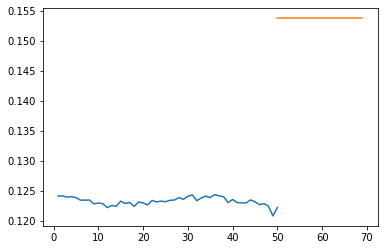

In [181]:
plt.plot(plot_act, result_multi['Exp Predictions'][940:])  #last 50 time steps from total of 990 time steps
plt.plot(plot_pred, future_output_multi)

In [182]:
pred_multi = result_multi['Exp Predictions'].tolist()

In [183]:
len(pred_multi)

990

In [184]:
pred_multi

[-0.0030191391706466675,
 -0.003040555864572525,
 -0.002818085253238678,
 -0.002456285059452057,
 -0.002992376685142517,
 -0.003350507467985153,
 -0.003028538078069687,
 -0.0032107792794704437,
 -0.0032063238322734833,
 -0.003076251596212387,
 -0.0027482062578201294,
 -0.002510908991098404,
 -0.0023520365357398987,
 -0.0022577978670597076,
 -0.0023698508739471436,
 -0.002381622791290283,
 -0.0023949556052684784,
 -0.002313554286956787,
 -0.0023460350930690765,
 -0.0023978613317012787,
 -0.0026583485305309296,
 -0.002687264233827591,
 -0.002403516322374344,
 -0.002235081046819687,
 -0.002182982861995697,
 -0.002215929329395294,
 -0.0023122690618038177,
 -0.002410832792520523,
 -0.0030293986201286316,
 -0.0032681338489055634,
 -0.0029062069952487946,
 -0.002370215952396393,
 -0.0024400539696216583,
 -0.0026828907430171967,
 -0.0026671551167964935,
 -0.0024851709604263306,
 -0.0022155754268169403,
 -0.0021280981600284576,
 -0.002005387097597122,
 -0.0019169524312019348,
 -0.00206684321165

In [185]:
pred_multi_future = [item for sublist in future_output_multi for item in sublist]
pred_multi_future

[0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553,
 0.1538015455007553]

In [186]:
#Extend helps us to fill the missing value with approx value
pred_multi.extend(pred_multi_future)
print('All Predicted List:', pred_multi)

All Predicted List: [-0.0030191391706466675, -0.003040555864572525, -0.002818085253238678, -0.002456285059452057, -0.002992376685142517, -0.003350507467985153, -0.003028538078069687, -0.0032107792794704437, -0.0032063238322734833, -0.003076251596212387, -0.0027482062578201294, -0.002510908991098404, -0.0023520365357398987, -0.0022577978670597076, -0.0023698508739471436, -0.002381622791290283, -0.0023949556052684784, -0.002313554286956787, -0.0023460350930690765, -0.0023978613317012787, -0.0026583485305309296, -0.002687264233827591, -0.002403516322374344, -0.002235081046819687, -0.002182982861995697, -0.002215929329395294, -0.0023122690618038177, -0.002410832792520523, -0.0030293986201286316, -0.0032681338489055634, -0.0029062069952487946, -0.002370215952396393, -0.0024400539696216583, -0.0026828907430171967, -0.0026671551167964935, -0.0024851709604263306, -0.0022155754268169403, -0.0021280981600284576, -0.002005387097597122, -0.0019169524312019348, -0.0020668432116508484, -0.0022381208

In [187]:
len(pred_multi)

1010

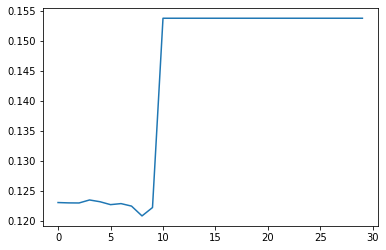

In [188]:
plt.plot(pred_multi[980:]) 

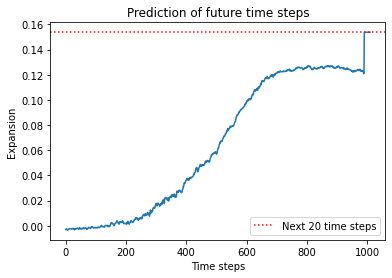

In [189]:
#Plotting final results with predicted value after 20 time steps
plt.plot(pred_multi)
plt.ylabel("Expansion")
plt.xlabel("Time steps")
plt.title("Prediction of future time steps")
plt.axhline(y=pred_multi[len(pred_multi)-1], color = 'red', linestyle = ':', label = 'Next 20 time steps')
plt.legend()

In [190]:
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:09:13.352002


### References:
1. Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J., Dive into Deep Learning. arXiv preprint arXiv:2106.11342.(2021). https://d2l.ai/index.html
2. Sepp Hochreiter; Jürgen Schmidhuber (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780. doi:10.1162/neco.1997.9.8.1735. PMID 9377276. S2CID 1915014.
3. Christopher Olah, Understanding LSTM Networks, https://colah.github.io/posts/2015-08-Understanding-LSTMs/
4. Md. Asif Rahman, Yang Lu, A time-dependent chemo-mechanical analysis of alkali-silica reaction for the disparate geometry of concrete meso-structure, Construction and Building Materials, Volume 211, 2019, Pages 847-857, ISSN 0950-0618. https://doi.org/10.1016/j.conbuildmat.2019.03.025.
5. Md. Asif Rahman, Yang Lu, Stochastic-Multiphysics Modeling of Concrete Alkali-Silica Reaction (ASR) Damage Subject to Global Warming and Climate Change Impacts. [Under Review]

"Thank You"